# ContentFusion: Leveraging GNNs to Recommend Audio for Video:

By *Emma Escandon, Neel Davar, and Ryan Miller*



This is the colab for our Medium article, which can be found at the following link. The code loads in graph data from the Spotify Million Playlist Dataset paired with IMDB movie datasets and uses Graph Neural Network (GNN) approaches for the automated song to video clip matching. More specifically, we use convolutional layers from GraphSAGE to match clips to playlists, and PinSage to make recommendation predictions of songs to match to the clip. Besides implementations of these GNN approaches, this colab includes various visualizations for conceptual aid.

NOTE: Please ensure that you are using a GPU for this notebook. In Colab, in order to enable this, all you must do is click on Runtime --> Change runtime type. From the dropdown menu, there should be a hardware accelator option. For this please select GPU. Once this is done you will have to disconnect and reconnect. After that you should be up and running!


Before proceeding, we need to install and import all of the necessary libraries. Installation of torch dependencies: scatter, sparse and geometric

In [58]:
# Install torch geometric

import os
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


In [59]:
# Libraries
import requests
import base64
import json
!pip install spotipy
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import itertools
import numpy as np
import networkx as nx


# Mount drive
#from google.colab import drive
#drive.mount('/content/drive')

# Sentiment Analysis, SentimentIntensityAnalyzer class
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load Spotify Data

For a large list of playlist ids, fetch the playlist description and list of songs for each playlist
and output 2 json files:
File 1: Contains the playlist id and description
File 2: Contains song id, song name, and each other field is the id of a playlist in which it occurs.

The aim is to capture thematic info about songs based on the playlists they're featured in. We would only use Spotify created mood/theme based playlists for this.

Along with these features, we also use temporal song features to create embeddings.

We'll use Word2vec to create embeddings for songs based on the descriptions of playlists they occur in. Similarly create Word2vec embeddings for the videos based on their descriptions so we'll have a way to map them to each other.

In [60]:
CLIENT_ID = '00fc9b6a4e5b467999acc5e3972606ed'
CLIENT_SECRET = '45574adf882947dda6628080497cd0d3'
SPOTIFY_API_URL = 'https://api.spotify.com/v1/'

def get_access_token(client_id, client_secret):
    auth_str = f'{client_id}:{client_secret}'
    encoded_auth = base64.b64encode(auth_str.encode()).decode()

    token_url = 'https://accounts.spotify.com/api/token'
    headers = {'Authorization': f'Basic {encoded_auth}'}
    data = {'grant_type': 'client_credentials'}

    response = requests.post(token_url, headers=headers, data=data)
    token_data = response.json()

    return token_data.get('access_token')

def get_playlist_info(playlist_url, access_token):
    playlist_id = playlist_url.split('/')[-1]

    playlist_api_url = f'{SPOTIFY_API_URL}playlists/{playlist_id}'
    headers = {'Authorization': f'Bearer {access_token}'}

    response = requests.get(playlist_api_url, headers=headers)
    playlist_data = response.json()

    return playlist_data

def update_songs_data(existing_songs_data, playlist_urls, access_token):
    playlist_names = set()  # Set to store unique playlist names

    for playlist_url in playlist_urls:
        playlist_data = get_playlist_info(playlist_url, access_token)
        if playlist_data:
            playlist_id = playlist_url
            playlist_name = playlist_data.get('name')
            playlist_description = playlist_data.get('description', "No description available")

            # Check for duplicate playlist names
            if playlist_name not in playlist_names:
                # Append playlist name to the set
                playlist_names.add(playlist_name)

                if 'tracks' in playlist_data:
                    tracks = playlist_data['tracks'].get('items', [])
                    for track_entry in tracks:
                        if 'track' in track_entry and track_entry['track'] is not None:
                            song = track_entry['track']
                            song_id = song.get('id')
                            song_name = song.get('name')
                            if song_id:
                                # Check if the song with the same ID already exists
                                existing_song = next((s for s in existing_songs_data if s["song_id"] == song_id), None)
                                if existing_song:
                                    # Update the playlists for the existing song
                                    existing_song_playlists = existing_song.get("playlists", {})
                                    existing_song_playlists[playlist_id] = {
                                        "name": playlist_name,
                                        "description": playlist_description
                                    }
                                else:
                                    # Create a new entry for the song
                                    song_info = {
                                        "song_id": song_id,
                                        "song_name": song_name,
                                        "playlists": {
                                            playlist_id: {
                                                "name": playlist_name,
                                                "description": playlist_description
                                            }
                                        }
                                    }
                                    existing_songs_data.append(song_info)

    # Save playlist names to a JSON file
    playlist_names_file = 'playlist_names.json'
    with open(playlist_names_file, 'w') as f:
        json.dump(list(playlist_names), f, indent=2)

    return existing_songs_data

if __name__ == '__main__':
    playlist_urls = [
    "https://open.spotify.com/playlist/37i9dQZF1DWSMyFeHM3son",
    "https://open.spotify.com/playlist/37i9dQZF1DX41cLva7hoYQ",
    "https://open.spotify.com/playlist/37i9dQZF1DX42rTd7wQPNO",
    "https://open.spotify.com/playlist/37i9dQZF1DWX3387IZmjNa",
    "https://open.spotify.com/playlist/37i9dQZF1DX7Z7kYpKKGTc",
    "https://open.spotify.com/playlist/37i9dQZF1DX4s3V2rTswzO",
    "https://open.spotify.com/playlist/37i9dQZF1DXcKW8VlJappa",
    "https://open.spotify.com/playlist/37i9dQZF1DX6drTZKzZwSo",
    "https://open.spotify.com/playlist/37i9dQZF1DX70TzPK5buVf",
    "https://open.spotify.com/playlist/37i9dQZF1DWXLeA8Omikj7",
    "https://open.spotify.com/playlist/37i9dQZF1DX6r25lY14UGk",
    "https://open.spotify.com/playlist/37i9dQZF1DX4EQOUdlKKG2",
    "https://open.spotify.com/playlist/37i9dQZF1DWTl4y3vgJOXW",
    "https://open.spotify.com/playlist/37i9dQZF1DX7jLQsJHPr0Z",
    "https://open.spotify.com/playlist/37i9dQZF1DX17TxDoLeXxl",
    "https://open.spotify.com/playlist/37i9dQZF1DXdDIhtzn7T2e",
    "https://open.spotify.com/playlist/37i9dQZF1DWSqmBTGDYngZ",
    "https://open.spotify.com/playlist/37i9dQZF1DX6fhMYWIyuww",
    "https://open.spotify.com/playlist/37i9dQZF1DWVbhm7gjxOsz",
    "https://open.spotify.com/playlist/37i9dQZF1DX1STMhgdmNBY",
    "https://open.spotify.com/playlist/37i9dQZF1DX8eMyhtzAuvp",
    "https://open.spotify.com/playlist/37i9dQZF1DX9pryhDLql25",
    "https://open.spotify.com/playlist/37i9dQZF1DWYzhk8ayyoEy",
    "https://open.spotify.com/playlist/37i9dQZF1DX5IDTimEWoTd",
    "https://open.spotify.com/playlist/37i9dQZF1DXdK49S1DyoyG",
    "https://open.spotify.com/playlist/37i9dQZF1DXa90jZU6E5GN",
    "https://open.spotify.com/playlist/37i9dQZF1DX4Vd1jJ7X9H8",
    "https://open.spotify.com/playlist/37i9dQZF1DX0VfLbJWWGKr",
    "https://open.spotify.com/playlist/37i9dQZF1DWV7EzJMK2FUI",
    "https://open.spotify.com/playlist/5n7wylHu4IS2IcmZ4rP06o",
    "https://open.spotify.com/playlist/1egRYqbzAU8kCoeWUbBBeD",
    "https://open.spotify.com/playlist/3nSKcSSzEMw7TyqxejMIjZ",
    "https://open.spotify.com/playlist/08qNpUNnRUjGxtyJOZh8IH",
    "https://open.spotify.com/playlist/62wW67yRcDrZunRQlgzsqU",
    "https://open.spotify.com/playlist/6LEgrh17368dWON69IU4gG",
    "https://open.spotify.com/playlist/7hKB7ggXpymJTbT5eshTIi",
    "https://open.spotify.com/playlist/37i9dQZF1DWVxpHBekDUXK",
    "https://open.spotify.com/playlist/6bpzZCSAxGEIjSPRfA9etL",
    "https://open.spotify.com/playlist/5Kw8F3qis9Zs4ajTTr98cC",
]

# Now you can use the 'playlist_urls' list in your Python code.


    file = 'song_info.json'

    try:
        with open(file, 'r') as f:
            existing_data = json.load(f)
    except FileNotFoundError:
        existing_data = {'songs': []}

    existing_songs_data = existing_data['songs']

    access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)

    updated_songs_data = update_songs_data(existing_songs_data, playlist_urls, access_token)

    existing_data['songs'] = updated_songs_data

    with open(file, 'w') as f:
        json.dump(existing_data, f, indent=2)




In [61]:
#read the song_info.json file
#for each song in the file:
  #fetch audio features from song metadata
  #fetch genre from artists
#rotate client ids


# Define your client IDs and secrets
CLIENT_IDS = ['b44a4e650bff4d348c9f0191d2f041d0', 'b62658b8f79d4332a2545add63592def', '85f27bd2db894ac4909a057648e56b8c', '83fb8e40b8764191aa8d9d321f0f9e67', 'a06a1215bd5b493b877d8f891e14a3c9','00fc9b6a4e5b467999acc5e3972606ed', 'a9d39bb6d0f84c2c90e3f6db72d17fcf', '70e623bab94341ebb7c8b5c73f74861c', '1c7b52d17259485997359caa6762c2c8']
CLIENT_SECRETS = ['41ff5e9b84d941488d9817b6ac3e70c0', 'b5fb44c2233745e681214d55273e5453', 'ed4727bc831347c693a7751aaaad5b60', 'f1cfcb185d4e4f03b1c25d2ae21ede96', '81a6c26af1b44efaa6b178555639bb31', '45574adf882947dda6628080497cd0d3', '8d3fe37f957b4cf7ad5eff4e3b8fea20', '0753d51f060d4ac08e432aae19964638', 'e9f322654d83435299f5350fe0aa996a']
SPOTIFY_API_URL = 'https://api.spotify.com/v1/'

def get_access_token(client_ids, client_secrets, index):
    if index < len(client_ids):
        client_id = client_ids[index]
        client_secret = client_secrets[index]

        auth_str = f'{client_id}:{client_secret}'
        encoded_auth = base64.b64encode(auth_str.encode()).decode()

        token_url = 'https://accounts.spotify.com/api/token'
        headers = {'Authorization': f'Basic {encoded_auth}'}
        data = {'grant_type': 'client_credentials'}
        print
        response = requests.post(token_url, headers=headers, data=data)

        # Check for a successful response (status code 200)
        if response.status_code == 200:
            token_data = response.json()
            return client_id, client_secret, token_data.get('access_token'), index
        elif response.status_code == 429:
            return get_access_token(client_ids, client_secrets, index + 1)

    # If all client IDs are exhausted, return None
    return index, index, index, index

# Define a function to get audio features
def get_audio_features(song_id, access_token):
    audio_features_url = f'{SPOTIFY_API_URL}audio-features/{song_id}'
    headers = {'Authorization': f'Bearer {access_token}'}

    response = requests.get(audio_features_url, headers=headers)

    if response.status_code == 200:
        audio_features_data = response.json()
        return audio_features_data
    else:
        print(f"Error fetching audio features for song ID {song_id}: {response.status_code}")
        return None

# Define a function to get artists and genres
def get_artists_and_genres(song_id, access_token):
    # Initialize the result
    result = {
        "genres": [],
        "artists": []
    }

    # Fetch track data using the /tracks/{id} endpoint
    track_data_url = f'{SPOTIFY_API_URL}tracks/{song_id}'
    headers = {'Authorization': f'Bearer {access_token}'}

    response = requests.get(track_data_url, headers=headers)

    if response.status_code == 200:
        track_info = response.json()

        # Extract artists
        artists = track_info.get('artists', [])

        for artist in artists:
            if 'id' in artist:
                artist_id = artist.get('id')
                artist_url = f'{SPOTIFY_API_URL}artists/{artist_id}'
                response = requests.get(artist_url, headers=headers)

                if response.status_code == 200:
                    artist_info = response.json()
                    artist_data = {
                        "id": artist_info.get('id'),
                        "name": artist_info.get('name')
                    }
                    result["artists"].append(artist_data)
                    result["genres"].extend(artist_info.get('genres', []))

    print(result)

    return result

if __name__ == '__main__':
    current_client_index = 0  # Initialize with the first client ID
    client_id, client_secret, access_token, current_client_index = get_access_token(CLIENT_IDS, CLIENT_SECRETS, current_client_index)
    print(client_id)

    # Check if all client IDs are exhausted
    if client_id is None:
        print("All client IDs are exhausted. Rate limit exceeded.")
    else:
        print(f"Access Token: {access_token}")

        # Read 'song_info.json' file
        with open('song_info.json', 'r') as song_info_file:
            songs_data = json.load(song_info_file)

        try:
            # Process each song entry
            for song_entry in songs_data['songs']:
                song_id = song_entry['song_id']
                song_name = song_entry.get('song_name', 'No Song Name')

                # Check if audio features, genres, and artists are already present
                if 'audio_features' not in song_entry or 'genres' not in song_entry or song_entry['audio_features'] is None or song_entry['artists'] is None:
                    # Audio features for the song
                    audio_features = get_audio_features(song_id, access_token)

                    if audio_features:
                        print(f"Song: {song_name}, Song ID: {song_id}")
                        print(f"Audio features: {audio_features}")
                        # Update song entry with audio features
                        song_entry['audio_features'] = audio_features

                        # Update the JSON file after processing the song
                        with open('song_info.json', 'w') as song_info_file:
                            json.dump(songs_data, song_info_file, indent=2)


                    # Fetch artists and genres for the song
                    result = get_artists_and_genres(song_id, access_token)

                    if result['artists']:
                        song_entry['artists'] = result['artists']

                    if result['genres']:
                        song_entry['genres'] = result['genres']

                    # Update the JSON file after processing the song
                    with open('song_info.json', 'w') as song_info_file:
                        json.dump(songs_data, song_info_file, indent=2)
        except KeyboardInterrupt:
            print("Keyboard Interrupt: Saving progress to JSON file.")
            with open('song_info.json', 'w') as song_info_file:
                json.dump(songs_data, song_info_file, indent=2)




b44a4e650bff4d348c9f0191d2f041d0
Access Token: BQCww2qomHVGUFI0QFj6R781hzw944KYj3Ed3SHWRCLf5ohNsclaTyCE7xmkWKCqLatotoBOsB2P_ZRhGgur8k5dmZ-HUu5mm44o41Hwm-krxrFFLB4
Error fetching audio features for song ID 11jVnpAewcZnIdLsq0BKJF: 429
{'genres': [], 'artists': []}
Error fetching audio features for song ID 03f7xZmt2wHCIDJBFPK8G4: 429
{'genres': [], 'artists': []}
Error fetching audio features for song ID 7brQHA2CgQpcMBiOlfiXYb: 429
{'genres': [], 'artists': []}
Error fetching audio features for song ID 45dAw6GXEsogcDF3NUgj3O: 429
{'genres': [], 'artists': []}
Error fetching audio features for song ID 2LGdO5MtFdyphi2EihANZG: 429
{'genres': [], 'artists': []}
Error fetching audio features for song ID 70LcF31zb1H0PyJoS1Sx1r: 429
{'genres': [], 'artists': []}
Error fetching audio features for song ID 1FWsomP9StpCcXNWmJk8Cl: 429
{'genres': [], 'artists': []}
Error fetching audio features for song ID 7w87IxuO7BDcJ3YUqCyMTT: 429
{'genres': [], 'artists': []}
Error fetching audio features for son


# Song 2 Graph

In [62]:
# Load the song datasets
!wget https://raw.githubusercontent.com/eeescandon/CS224W-Project/main/playlists_emotion_vector.csv
!wget https://raw.githubusercontent.com/eeescandon/CS224W-Project/main/song_info-7.json
!wget https://raw.githubusercontent.com/eeescandon/CS224W-Project/main/playlist_emotions_scaled.csv

--2023-12-15 00:29:58--  https://raw.githubusercontent.com/eeescandon/CS224W-Project/main/playlists_emotion_vector.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22712 (22K) [text/plain]
Saving to: ‘playlists_emotion_vector.csv.1’

playlists_emotion_v 100%[===================>]  22.18K  --.-KB/s    in 0.006s  

2023-12-15 00:29:59 (3.83 MB/s) - ‘playlists_emotion_vector.csv.1’ saved [22712/22712]

--2023-12-15 00:29:59--  https://raw.githubusercontent.com/eeescandon/CS224W-Project/main/song_info-7.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting re

In [63]:
import torch
from torch_geometric.data import Data
import json

def convert_to_bipartite_graph(data_json):
    all_song_features = []
    all_playlist_features = {}
    song_index = {}
    edges = []
    total_playlists = 0
    songs = []

    for song_data in data_json["songs"]:
        song_id = song_data["song_id"]
        song_name = song_data["song_name"]

        # Extract audio features for the song
        audio_features = song_data["audio_features"]

        genres = song_data.get("genres", [])

        song_features = {
            "type": "song",
            "id": song_id,
            "name": song_name,
            **audio_features,
            "genres": genres,
            "artists": song_data["artists"]
        }
        songs.append(song_features)

        if song_id not in song_index:
            song_index[song_id] = 133 + len(all_song_features)
            all_song_features.append(song_features)

        song_idx = song_index[song_id]

        # Iterate over playlists for the current song
        for playlist_url, playlist_info in song_data["playlists"].items():
            if playlist_url not in all_playlist_features:
                playlist_idx = len(all_playlist_features)
                playlist_features = {
                    "type": "playlist",
                    "url": playlist_url,
                    "name": playlist_info["name"],
                    "description": playlist_info.get("description", ""),
                    "playlist_genres": set()
                }

                all_playlist_features[playlist_url] = {
                    "index": playlist_idx,
                    "features": playlist_features
                }
                total_playlists+=1

            # Use the playlist index obtained above
            playlist_idx = all_playlist_features[playlist_url]["index"]

            sgenres = song_data.get("genres", [])

            # Update playlist genres after initializing the playlist entry
            all_playlist_features[playlist_url]["features"]["playlist_genres"].update(sgenres)

            # Create edges between song and playlist
            edges.append((song_idx, playlist_idx))

    # Convert data to PyG format
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # Extract features into separate tensors for songs and playlists
    x_song = torch.tensor([[item.get("danceability"), item.get("energy"), item.get("key"),
                            item.get("loudness"), item.get("mode"), item.get("speechiness"),
                            item.get("acousticness"), item.get("instrumentalness"),
                            item.get("liveness"), item.get("valence"), item.get("tempo")]
                           for item in all_song_features], dtype=torch.float)

    x_playlist = [entry["features"] for entry in all_playlist_features.values()]

    data = Data(x_song=x_song, x_playlist=x_playlist, edge_index=edge_index, songs = songs)
    print(total_playlists)

    return data

# Load JSON data
with open("/content/song_info-7.json", "r") as file:
    data_json = json.load(file)

# Convert to bipartite graph
bipartite_data = convert_to_bipartite_graph(data_json)

print("Edge Index:")
print(bipartite_data.edge_index)
print("Number of Nodes:")
print(bipartite_data.num_nodes)
print("Number of Edges:")
print(bipartite_data.num_edges)
# Print the number of song and playlist nodes
num_song_nodes = bipartite_data.x_song.size(0)
num_playlist_nodes = len(bipartite_data.x_playlist)


print(bipartite_data.x_song.size(0))
print(f"Number of song nodes: {num_song_nodes}")
print(f"Number of playlist nodes: {num_playlist_nodes}")
print("\nSong Features:")
print(bipartite_data.x_song)

print("\nPlaylist Features:")
print(bipartite_data.x_playlist)

max_destination = bipartite_data.edge_index[1].max().item()

print("Max Destination Node Value:", max_destination)



133
Edge Index:
tensor([[ 133,  133,  133,  ..., 8570, 8571, 8572],
        [   0,    1,    2,  ...,  116,  116,  116]])
Number of Nodes:
8573
Number of Edges:
10691
8440
Number of song nodes: 8440
Number of playlist nodes: 133

Song Features:
tensor([[6.7100e-01, 8.7600e-01, 7.0000e+00,  ..., 8.2300e-02, 9.6400e-01,
         1.3000e+02],
        [6.2100e-01, 8.7300e-01, 5.0000e+00,  ..., 8.2400e-02, 8.7300e-01,
         9.7960e+01],
        [6.2000e-01, 7.6100e-01, 1.0000e+01,  ..., 2.6900e-01, 1.9400e-01,
         1.4600e+02],
        ...,
        [5.4200e-01, 9.1400e-01, 0.0000e+00,  ..., 7.4400e-01, 5.7600e-01,
         1.5399e+02],
        [8.5400e-01, 7.1000e-01, 4.0000e+00,  ..., 1.6600e-01, 8.1800e-01,
         1.0689e+02],
        [8.8200e-01, 4.5600e-01, 7.0000e+00,  ..., 1.2600e-01, 4.5200e-01,
         1.0036e+02]])

Playlist Features:
[{'type': 'playlist', 'url': 'https://open.spotify.com/playlist/37i9dQZF1DWYMroOc5KTTh', 'name': 'Serotonin', 'description': '100% good vibe

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/storage.py:327: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'songs', 'x_playlist', 'x_song', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


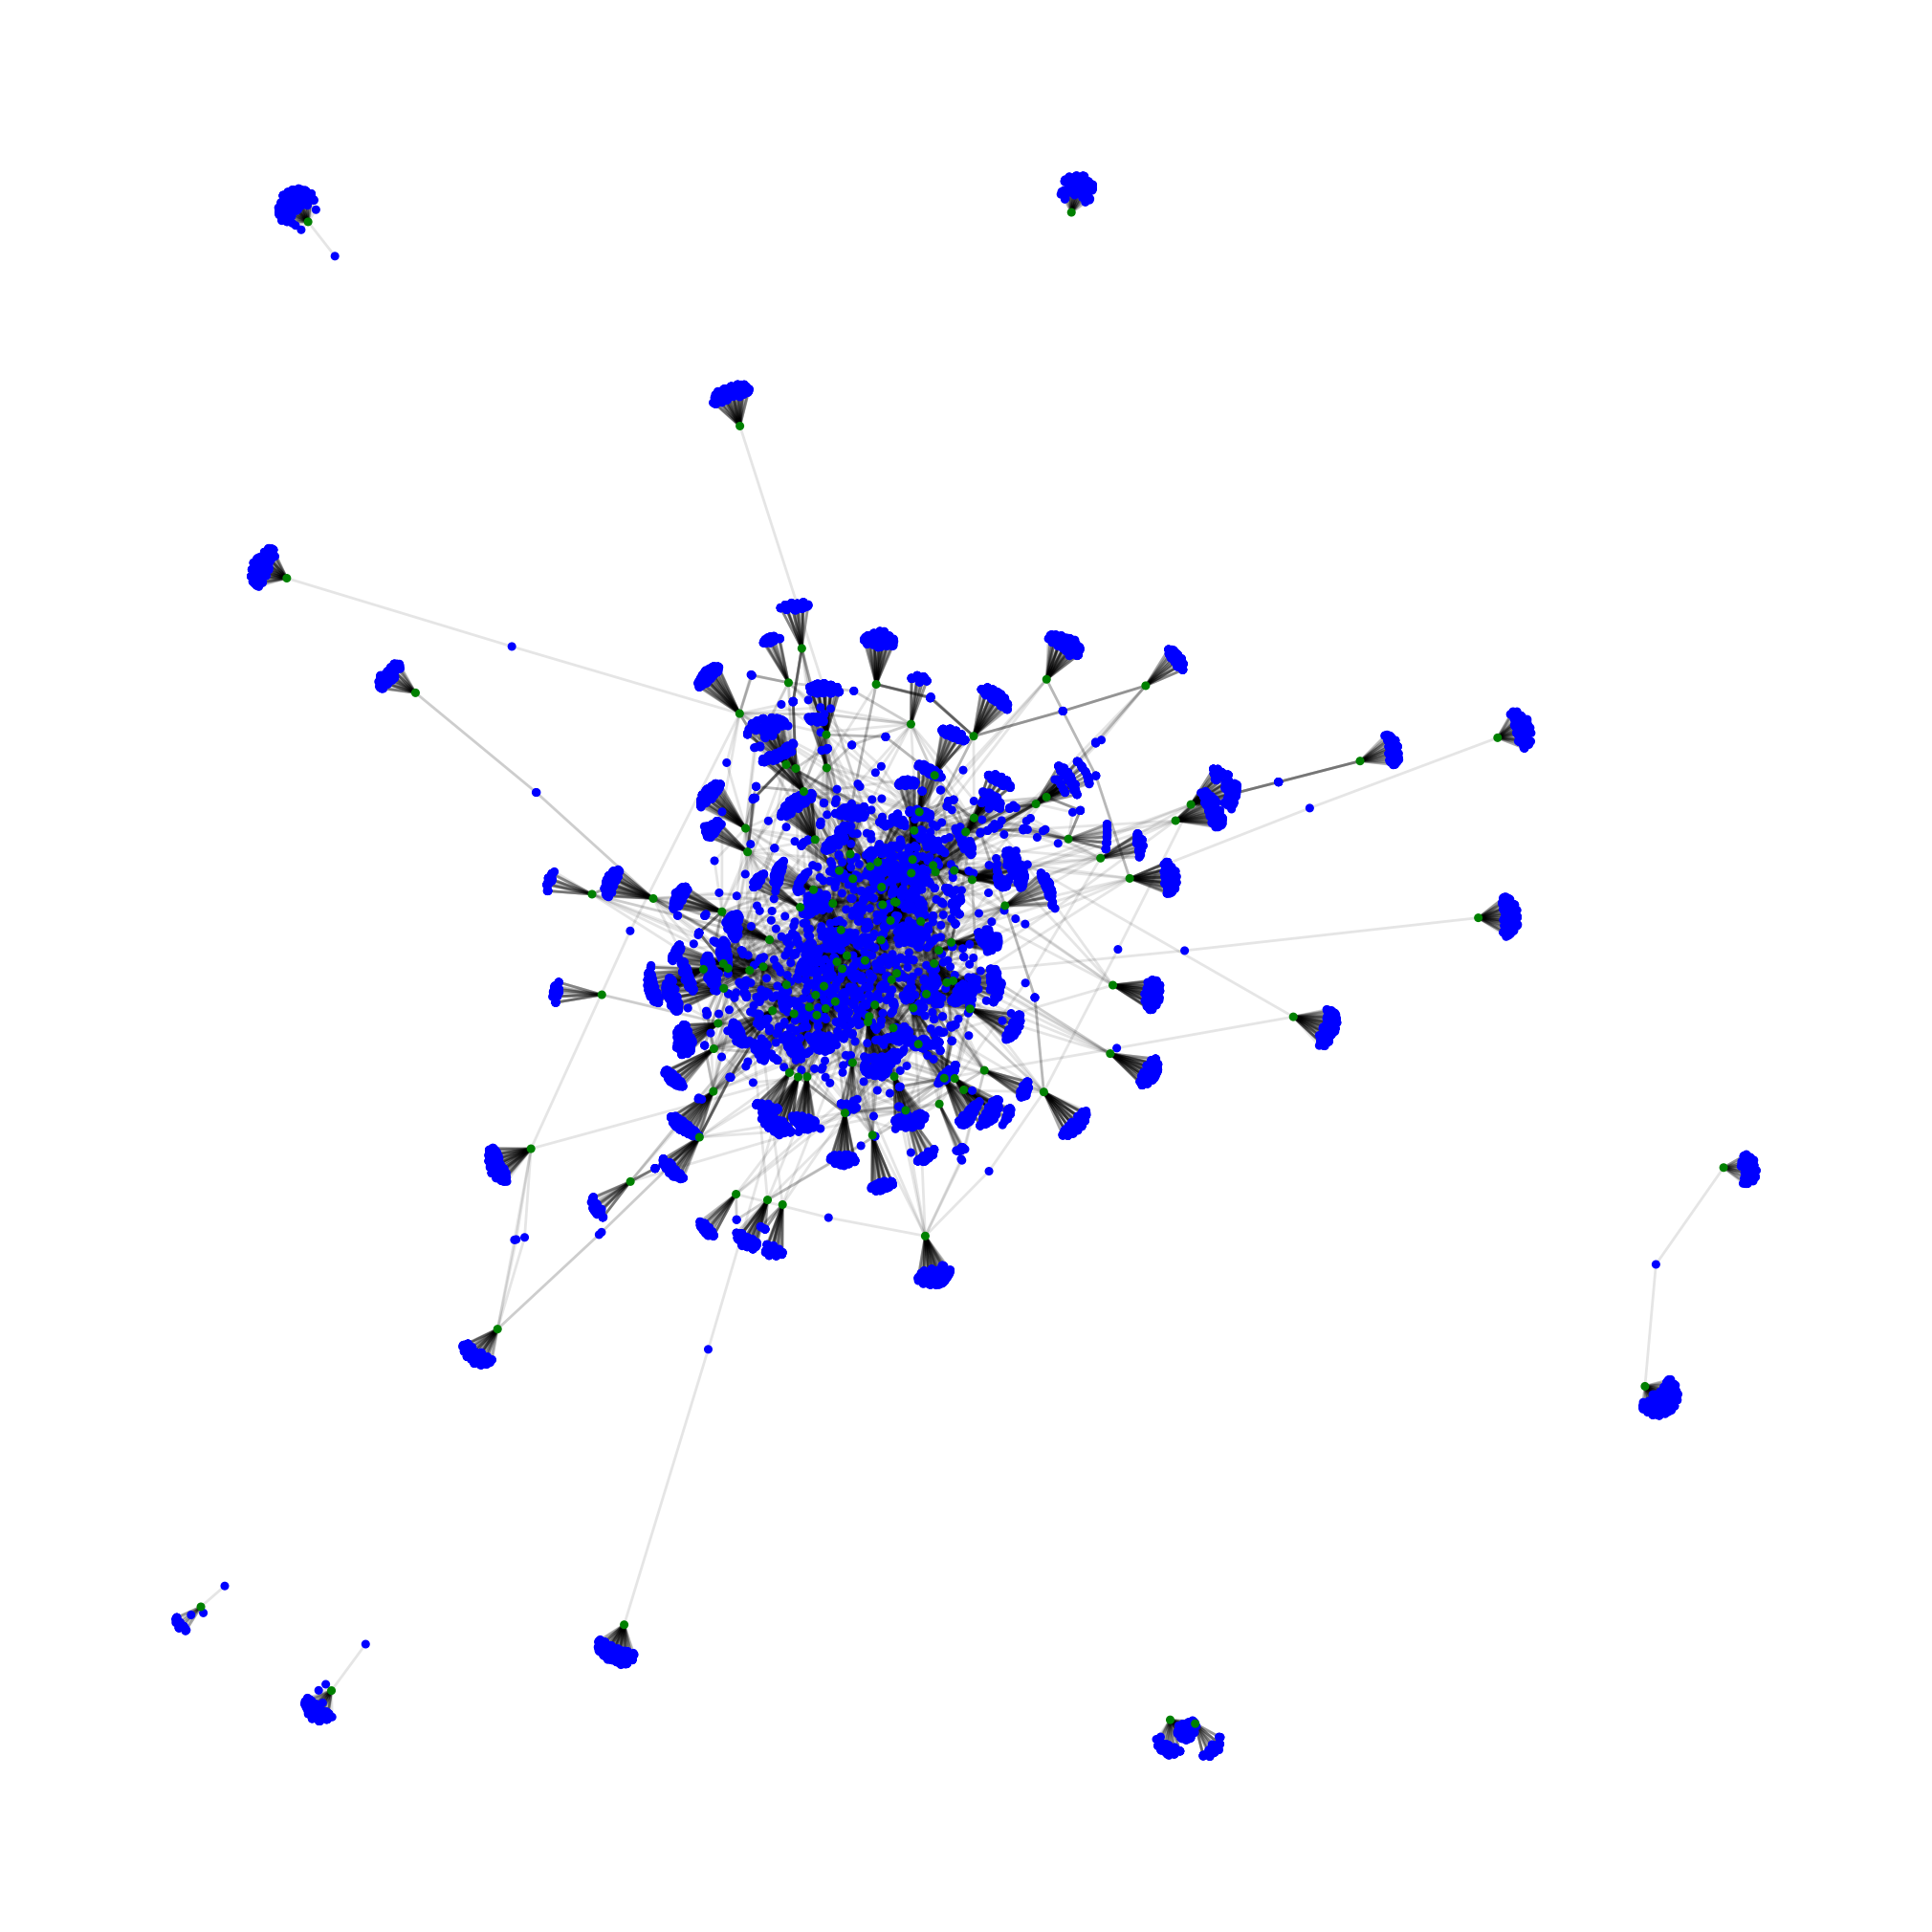

In [64]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_bipartite_graph(data):
    G = nx.Graph()

    # Add song nodes
    for i in range(data.x_song.size(0)):
        G.add_node(i+133, type='song')

    # Add playlist nodes
    playlist_offset = data.x_song.size(0)
    for i in range(len(data.x_playlist)):
        G.add_node(i, type='playlist')

    # Add edges
    for edge in data.edge_index.t().tolist():
        G.add_edge(*edge)

    # Define node colors
    color_map = ['blue' if G.nodes[node]['type'] == 'song' else 'green' for node in G]
    plt.figure(figsize=(20,20))
    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, cmap=plt.get_cmap('coolwarm'), node_color=color_map, node_size=30, width=2, edge_color=(0, 0, 0, 0.1))
    plt.show()
    return G

# Visualize graph
G = visualize_bipartite_graph(bipartite_data)


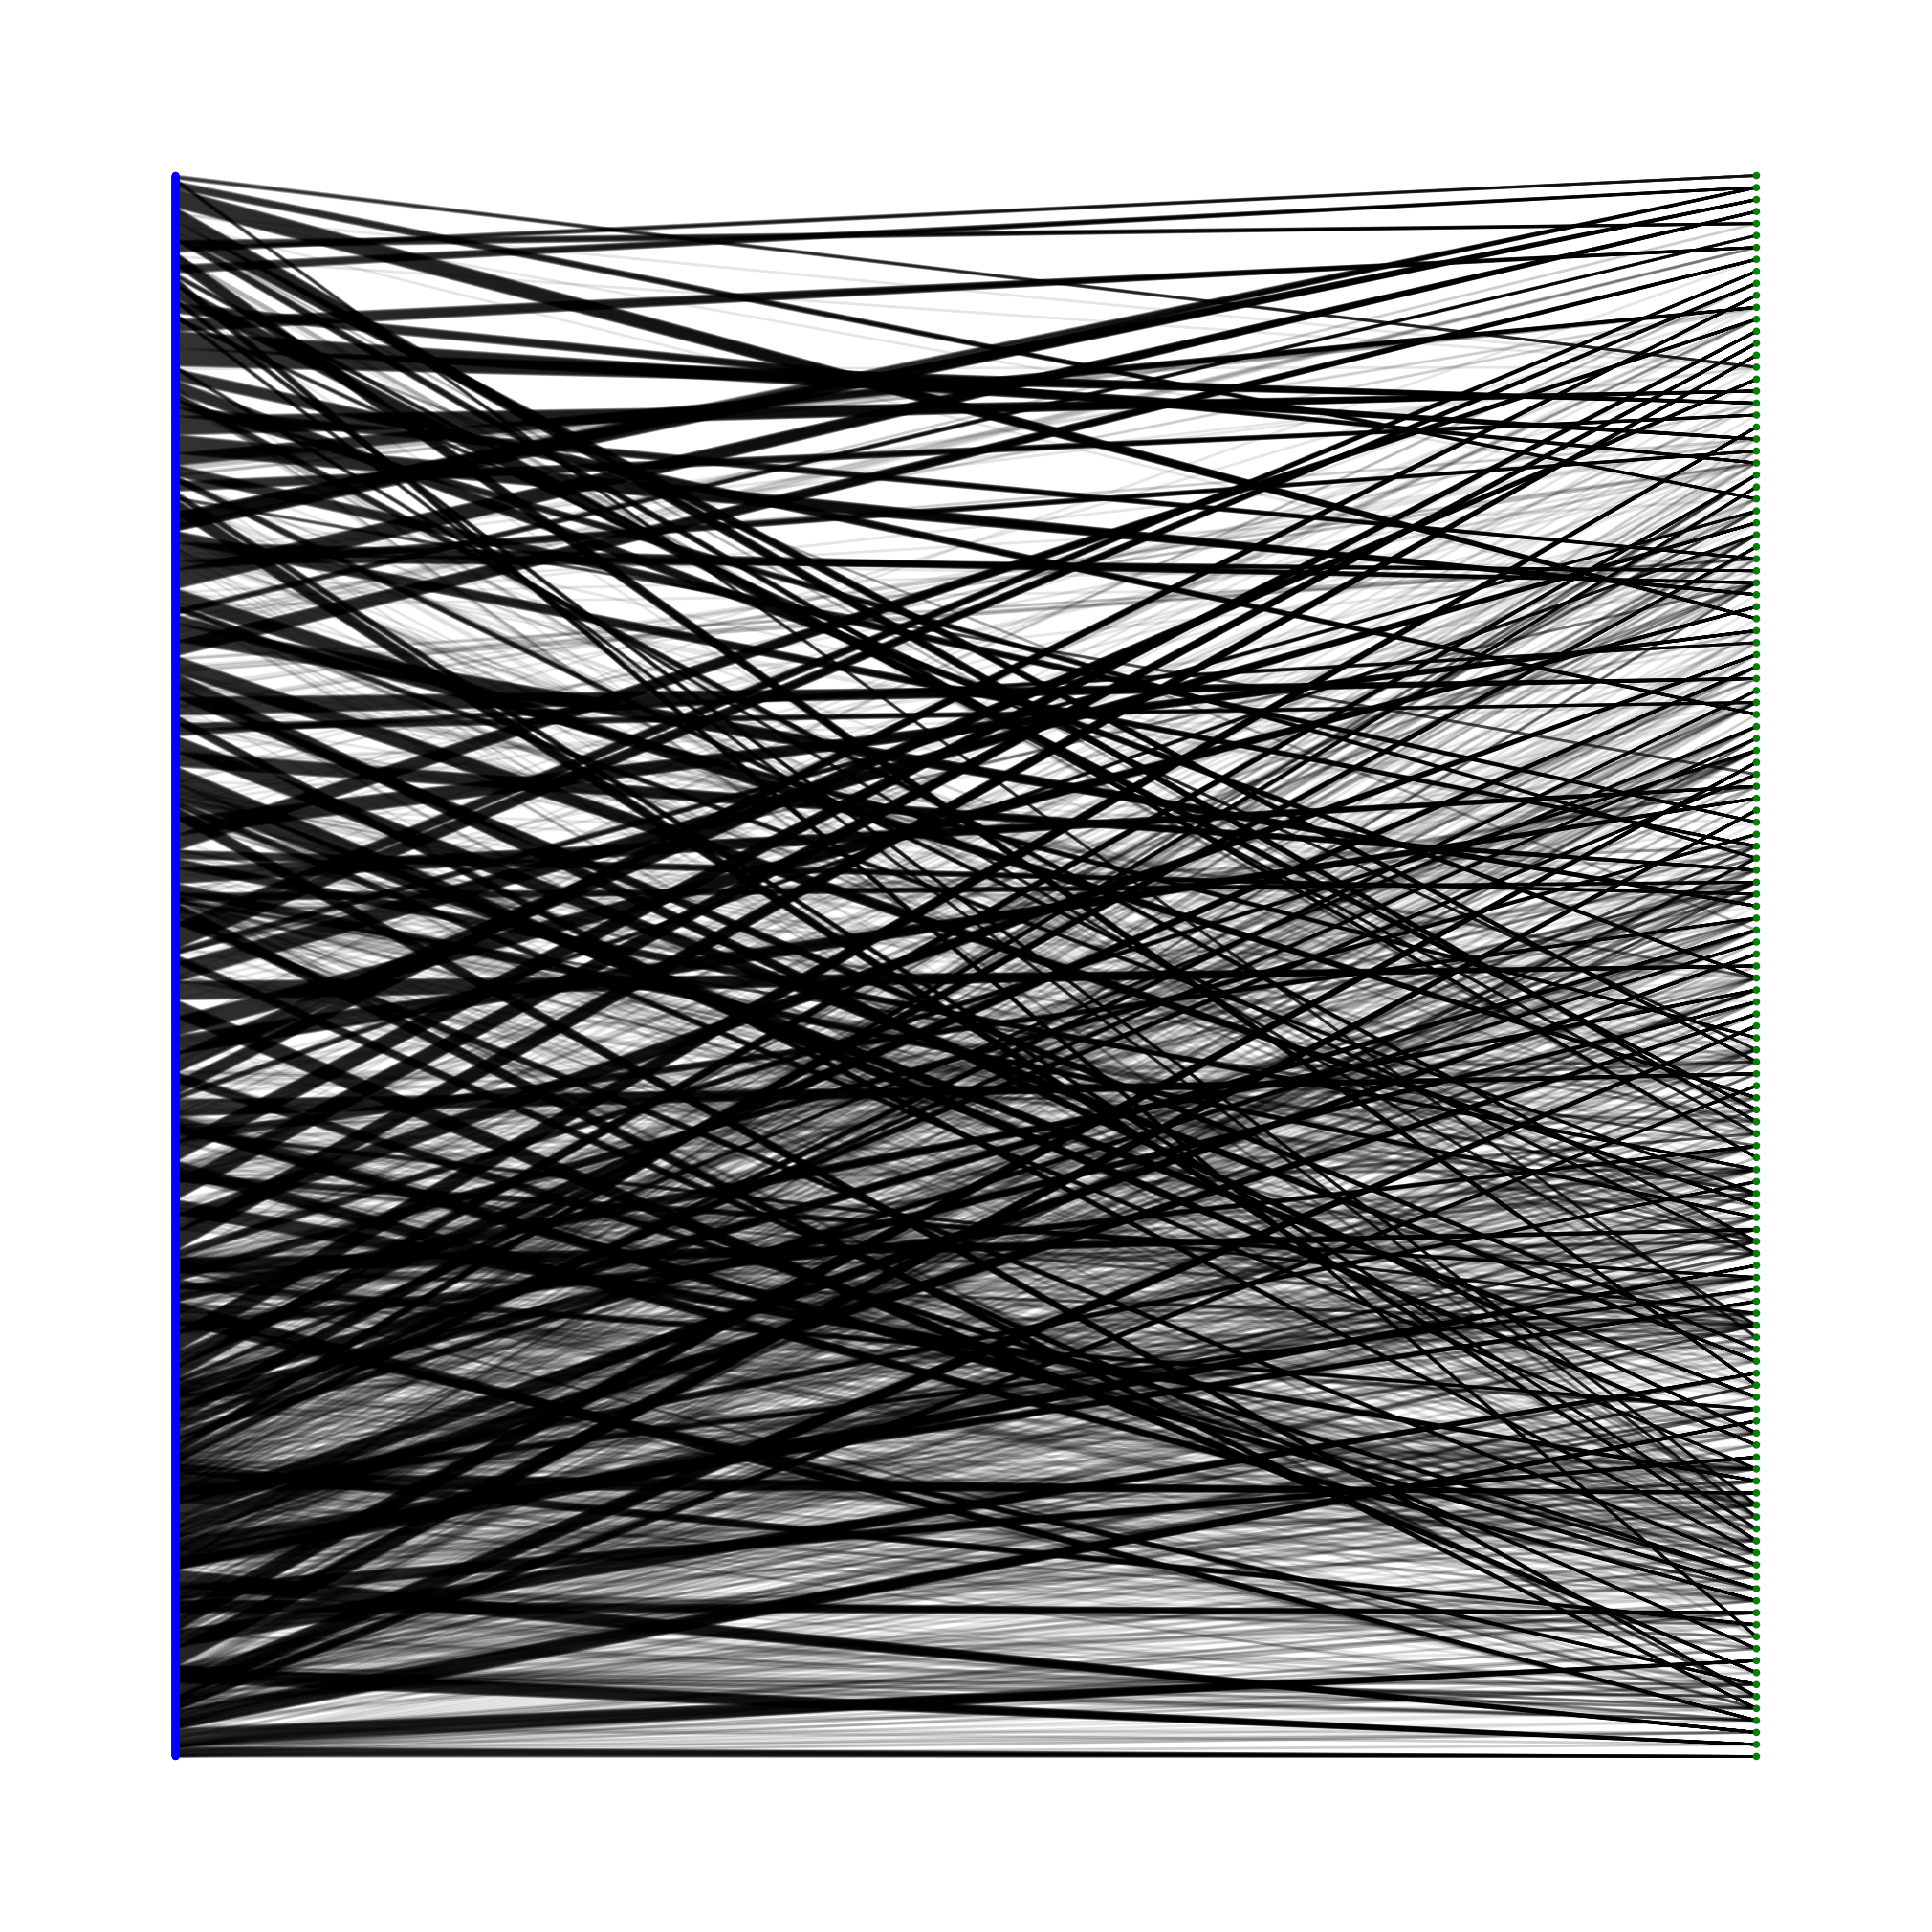

In [65]:
def visualize_bipartite(Graph):
    # Define node colors
    color_map = ['blue' if G.nodes[node]['type'] == 'song' else 'green' for node in G]
    plt.figure(figsize=(20,20))

    # Use bipartite layout
    top_nodes = {n for n, d in G.nodes(data=True) if d['type'] == 'song'}
    pos = nx.bipartite_layout(G, top_nodes)

    # Draw the graph
    nx.draw(G, pos, node_color=color_map, node_size=20, width=2, edge_color=(0, 0, 0, 0.1))
    plt.show()
    return G

# Visualize graph
G2 = visualize_bipartite(G)

Aggregate audio features for each node in order to provide initial node embeddings for the playlists

In [66]:
import torch

# Using the edge index
# Get the unique destination nodes (playlist nodes)
unique_destinations = torch.unique(bipartite_data.edge_index[1])

# Dictionary to store aggregated features for each destination node
aggregated_playlist_features = {}

# Offset used to differentiate source and destination nodes
offset = 133

# Iterate over unique destination nodes
for destination_node in unique_destinations:
    # Find the source nodes (songs) connected to the current destination node
    connected_sources = bipartite_data.edge_index[0][bipartite_data.edge_index[1] == destination_node]

    # Check if there are connected source nodes
    if len(connected_sources) > 0:
        # Adjust indices to get the correct index within x_song
        adjusted_sources = connected_sources - offset

        # Extract features for connected songs
        connected_song_features = bipartite_data.x_song[adjusted_sources]

        # Calculate average for all features except mode and key
        avg_playlist_features = connected_song_features.sum(dim=0)

        # Find the most frequently occurring mode and key in the playlist
        mode_value, _ = torch.mode(connected_song_features[:, 4])  # Assuming mode is at index 4
        key_value, _ = torch.mode(connected_song_features[:, 2])   # Assuming key is at index 2

        # Update mode and key in the average playlist features
        avg_playlist_features[4] = mode_value
        avg_playlist_features[2] = key_value

        # Store the aggregated features for the destination node
        aggregated_playlist_features[destination_node.item()] = avg_playlist_features

# Convert the aggregated features to a tensor
playlist_features_tensor = torch.stack(list(aggregated_playlist_features.values()))

print("Aggregated Playlist Features Tensor:")
print(playlist_features_tensor)

Aggregated Playlist Features Tensor:
tensor([[3.6342e+01, 3.6503e+01, 4.0000e+00,  ..., 9.3962e+00, 2.9689e+01,
         5.9805e+03],
        [6.3751e+01, 6.3908e+01, 1.0000e+00,  ..., 1.5645e+01, 4.7656e+01,
         1.1256e+04],
        [6.9325e+01, 6.2750e+01, 0.0000e+00,  ..., 1.5421e+01, 4.9972e+01,
         1.1557e+04],
        ...,
        [4.7583e+01, 1.6057e+01, 5.0000e+00,  ..., 1.2432e+01, 1.5166e+01,
         9.9066e+03],
        [4.5835e+01, 1.5019e+01, 0.0000e+00,  ..., 1.3380e+01, 1.5928e+01,
         9.9289e+03],
        [5.6458e+00, 2.3340e+00, 4.0000e+00,  ..., 4.4786e+00, 3.4201e+00,
         2.2654e+03]])


Clustering playlists based on audio features

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


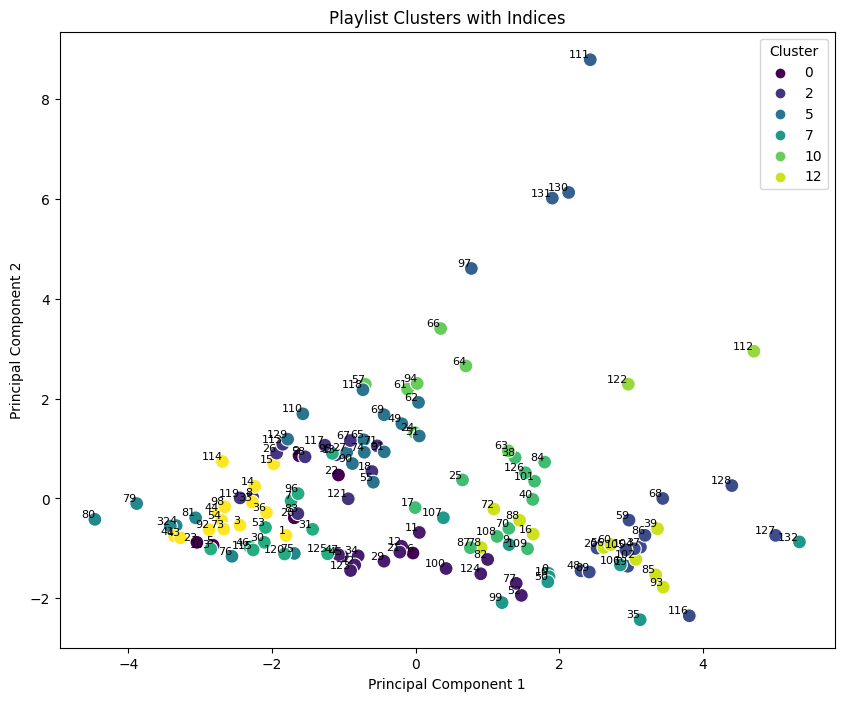

Cluster 1: Playlists [ 2  5  6 22 23 28]
Cluster 2: Playlists [ 11  12  21  29  34  42  45  47  52  77  82 100 123 124]
Cluster 3: Playlists [  8  13  18  26  58  67  71  83 113 117 119 121]
Cluster 4: Playlists [ 19  20  37  48  59  68  86  89 104 105 116 127 128]
Cluster 5: Playlists [ 97 111 130 131]
Cluster 6: Playlists [ 27  49  51  55  62  65  69  74  90  91 110 118 129]
Cluster 7: Playlists [ 4 32 75 76 79 80 81]
Cluster 8: Playlists [  0   9  10  35  50  99 106 107 132]
Cluster 9: Playlists [  7  30  31  46  53  95  96 103 115 120 125]
Cluster 10: Playlists [ 17  25  38  40  70  84  87 101 108 109 126]
Cluster 11: Playlists [24 57 61 63 64 66 94]
Cluster 12: Playlists [112 122]
Cluster 13: Playlists [ 16  39  56  60  72  78  85  88  93 102]
Cluster 14: Playlists [  1   3  14  15  33  36  41  43  44  54  73  92  98 114]
tensor([[ 133,  133,  133,  ..., 8570, 8571, 8572],
        [   0,    1,    2,  ...,  116,  116,  116]])


In [67]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


playlist_features_np = playlist_features_tensor.numpy()

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(playlist_features_np)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_standardized)

# Apply KMeans clustering
num_clusters = 14
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features_standardized)

# Visualize clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=clusters, palette='viridis', s=100)

# Annotate each point with its index
for i, (x, y) in enumerate(features_pca):
    plt.text(x, y, str(i), fontsize=8, ha='right', va='bottom')

plt.title('Playlist Clusters with Indices')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

for i in range(num_clusters):
    playlist_indices = np.where(clusters == i)[0]
    print(f'Cluster {i + 1}: Playlists {playlist_indices}')

print(bipartite_data.edge_index)


We want augment our graph by adding edges between playlists in the same cluster

In [108]:
# Create a mapping from playlist index to cluster index
playlist_to_cluster = {i: cluster for i, cluster in enumerate(clusters)}

# Update edge_index to connect playlists in the same cluster
cluster_edges = []
for i in range(len(clusters)):
    cluster_indices = [j for j, c in enumerate(clusters) if c == i]
    for index in range(len(cluster_indices)):
        for index2 in range(index, len(cluster_indices)):
            if cluster_indices[index] != cluster_indices[index2]:
                cluster_edges.append((cluster_indices[index], cluster_indices[index2]))

# Concatenate existing and new edges
existing_edges = bipartite_data.edge_index
new_edges = torch.tensor(cluster_edges, dtype=torch.long).t().contiguous()
all_edges = torch.cat([existing_edges, new_edges], dim=1)

print(all_edges)

tensor([[133, 133, 133,  ...,  92,  92,  98],
        [  0,   1,   2,  ...,  98, 114, 114]])


Feed in CSV File

In [109]:
import pandas as pd

# Load the CSV file
csv_path = 'playlist_emotions_scaled.csv'  # Replace with your actual file path
df = pd.read_csv(csv_path)

# Extract relevant columns
emotion_columns = df.columns[-14:]  # Assuming the last 12 columns are emotion-related

# Initialize an empty list to store emotion vectors for all playlists
all_emotion_vectors = []

# Iterate over rows/playlists
for _, row in df.iterrows():
    # Extract values for the emotion columns
    emotion_values = row[emotion_columns].values.astype(float)

    # Convert to PyTorch tensor
    emotion_tensor = torch.tensor(emotion_values, dtype=torch.float)

    # Reshape to a 1x12 vector
    emotion_vector = emotion_tensor.view(1, -1)

    # Append to the list
    all_emotion_vectors.append(emotion_vector)

# Concatenate all emotion vectors to create a tensor
all_emotion_tensors = torch.cat(all_emotion_vectors, dim=0)

print("All Emotion Vectors:")
print(all_emotion_tensors)

All Emotion Vectors:
tensor([[4., 2., 5.,  ..., 0., 0., 0.],
        [5., 0., 5.,  ..., 0., 0., 5.],
        [4., 3., 5.,  ..., 0., 0., 5.],
        ...,
        [0., 4., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 4., 0.]])


In [110]:
#If we want to use audio features as input
bipartite_data.y = all_emotion_tensors
bipartite_data.x = torch.cat([playlist_features_tensor, bipartite_data.x_song], dim=0)
#In case we want to use emotion vectors directly
bipartite_data.x = torch.cat([all_emotion_tensors, torch.zeros(8440,14)], dim=0)


GraphSAGE Weighted Using Emotion Vector as Input

In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
class GraphSAGEWeighted(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=10, dropout=0.2, num_playlist_nodes=133):
        super(GraphSAGEWeighted, self).__init__()
        self.num_layers = num_layers
        # Initialize the layers with weight decay
        self.conv_layers = nn.ModuleList([
            SAGEConv(input_dim if i == 0 else hidden_dim, hidden_dim, aggr='add', normalize=True) for i in range(num_layers)
        ])
        self.final_layer = SAGEConv(hidden_dim, output_dim, aggr='add', normalize=True)
        # Skip connection layer for playlist nodes
        self.playlist_skip = nn.Linear(input_dim, hidden_dim)
        self.num_playlist_nodes = num_playlist_nodes
        self.dropout = nn.Dropout(dropout)  # Add dropout layer
        self.weight_decay_factor = 0.5  # Adjust the weight decay factor as needed
        # List to store embeddings from each layer
        self.layer_embeddings = []
    def forward(self, x, edge_index):
        self.layer_embeddings = []  # Reset the list for each forward pass
        # Apply the first GraphSAGE layer
        x = self.conv_layers[0](x, edge_index)
        self.layer_embeddings.append(x.clone())
        # Separate playlist nodes and apply skip connection
        playlist_indices = torch.arange(self.num_playlist_nodes)
        playlist_embedding = self.playlist_skip(x[playlist_indices])
        # Apply additional hidden layers
        for i in range(1, self.num_layers):  # Start from the second layer
            x_prev = x.clone()  # Save the previous layer’s embedding
            x = F.relu(self.conv_layers[i](x, edge_index))
            x = self.dropout(x)
            # Apply weight decay
            #decayed_embedding = x_prev * (self.weight_decay_factor ** i)
            x[playlist_indices] = (x[playlist_indices] + x_prev[playlist_indices]) / 2
            # Store the current layer’s embedding
            self.layer_embeddings.append(x.clone())
        # Apply the final GraphSAGE layer
        x = self.final_layer(x, edge_index)
        # Update playlist nodes with skip connection
        x[playlist_indices] = (x[playlist_indices] + playlist_embedding) / 2
        # Store the final layer’s embedding
        self.layer_embeddings.append(x.clone())
        return F.relu(x)
    def get_weighted_average_embedding(self):
        # Calculate weights based on layer index
        weights = [self.weight_decay_factor ** i for i in range(self.num_layers + 1)]
        # Normalize weights to sum to 1
        weights_sum = sum(weights)
        weights = [w / weights_sum for w in weights]
        # Calculate the weighted average embedding
        weighted_average_embedding = sum(w * self.layer_embeddings[i] for i, w in enumerate(weights))
        return weighted_average_embedding



In [112]:
# Use emotion vectors as inputs
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing, global_add_pool
from torch_geometric.utils import add_self_loops, degree


input_dim_playlist = 14
hidden_dim= 14
output_dim = 14

# Initialize model
model = GraphSAGEWeighted(input_dim_playlist, hidden_dim, output_dim)

playlist_emotion_vectors = all_emotion_tensors
edge_index = bipartite_data.edge_index
bipartite_data.x = torch.cat([all_emotion_tensors, torch.zeros(8440,14)], dim=0) #initialize song embeddings as all zeros
edge_index = bipartite_data.edge_index  # Replace with actual edge indices

# Forward pass
gsw_emotion_vectors = model(bipartite_data.x , edge_index)

print(gsw_emotion_vectors[133:])

tensor([[0.4095, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2242],
        [0.4163, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2118],
        [0.4544, 0.0000, 0.0427,  ..., 0.0580, 0.0000, 0.1032],
        ...,
        [0.3223, 0.0000, 0.0000,  ..., 0.1022, 0.0000, 0.2040],
        [0.4613, 0.0000, 0.0000,  ..., 0.0130, 0.0000, 0.1151],
        [0.2181, 0.0000, 0.0000,  ..., 0.1438, 0.0000, 0.2165]],
       grad_fn=<SliceBackward0>)


SimpleGCN implementation

In [113]:

import torch.nn.functional as F
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
class SimpleGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.1, num_playlist_nodes=133):
        super(SimpleGCN, self).__init__()
        self.num_layers = num_layers
        self.conv_layers = nn.ModuleList([
            GCNConv(input_dim if i == 0 else hidden_dim, hidden_dim, aggr='add') for i in range(num_layers)
        ])
        self.final_layer = GCNConv(hidden_dim, output_dim, aggr='mean')
        self.num_playlist_nodes = num_playlist_nodes
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        # Apply the first GCN layer
        x = self.conv_layers[0](x, edge_index)
        # Separate playlist nodes
        playlist_indices = torch.arange(self.num_playlist_nodes)
        playlist_embedding = x[playlist_indices]
        # Apply additional hidden layers
        for i in range(1, self.num_layers):  # Start from the second layer
            x = self.conv_layers[i](x, edge_index)
            x = self.dropout(x)
        # Apply the final GCN layer
        x = self.final_layer(x, edge_index)
        # Update playlist nodes
        x[playlist_indices] += playlist_embedding
        return x

In [114]:
input_dim_playlist = 14
hidden_dim = 14
output_dim = 14

# Initialize model
epochs = 2
song_vectors = torch.ones(8440,14)*0.2
bipartite_data.x = torch.cat([all_emotion_tensors, song_vectors], dim=0)
#We want experiment running the model multiple times and feed in the embedding from the previous one as initial embedding to the next one.
for i in range(epochs):
  model = SimpleGCN(input_dim_playlist, hidden_dim, output_dim)
  edge_index = bipartite_data.edge_index

  # Forward pass
  emotion_vectors = model(bipartite_data.x , edge_index)
  song_vectors = emotion_vectors[133:]
  bipartite_data.x = emotion_vectors


sgcn_emotion_vectors = F.softmax(emotion_vectors) #softmax gives us a vector of probabilities
print(sgcn_emotion_vectors[133:])
print(sgcn_emotion_vectors[0])

tensor([[0.0862, 0.0653, 0.0611,  ..., 0.0504, 0.0752, 0.0738],
        [0.0757, 0.0707, 0.0615,  ..., 0.0542, 0.0698, 0.0664],
        [0.0716, 0.0728, 0.0673,  ..., 0.0521, 0.0641, 0.0607],
        ...,
        [0.0784, 0.0720, 0.0577,  ..., 0.0435, 0.0713, 0.0643],
        [0.0822, 0.0681, 0.0647,  ..., 0.0546, 0.0734, 0.0747],
        [0.0800, 0.0686, 0.0547,  ..., 0.0455, 0.0680, 0.0636]],
       grad_fn=<SliceBackward0>)
tensor([0.0092, 0.5380, 0.0181, 0.0424, 0.0095, 0.1109, 0.0022, 0.0506, 0.0214,
        0.0913, 0.0409, 0.0445, 0.0130, 0.0080], grad_fn=<SelectBackward0>)


<ipython-input-114-9b0a49ea57d9>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sgcn_emotion_vectors = F.softmax(emotion_vectors) #softmax gives us a vector of probabilities


In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Test Song

In [115]:
print(bipartite_data.songs[1000]["name"])
print(bipartite_data.songs[1000]["artists"])
print(gsw_emotion_vectors[132+1000])
print(sgcn_emotion_vectors[132+1000])
#print(emotion_vectors_1[132+64])
#print(F.softmax(emotion_vectors_2[132+64]))

Wannabe
[{'id': '0uq5PttqEjj3IH1bzwcrXF', 'name': 'Spice Girls'}]
tensor([0.2203, 0.0000, 0.0121, 0.0000, 0.0000, 0.0000, 0.2162, 0.2249, 0.0000,
        0.3385, 0.0000, 0.0000, 0.0000, 0.2378], grad_fn=<SelectBackward0>)
tensor([0.0678, 0.0724, 0.0701, 0.0668, 0.0699, 0.0776, 0.0773, 0.0752, 0.0772,
        0.0632, 0.0744, 0.0685, 0.0713, 0.0683], grad_fn=<SelectBackward0>)


# Load Movie Dataset

In [77]:
!wget https://raw.githubusercontent.com/m-bain/CondensedMovies/master/data/metadata/movies.csv
!wget https://raw.githubusercontent.com/m-bain/CondensedMovies/master/data/metadata/movie_info.csv
!wget https://raw.githubusercontent.com/m-bain/CondensedMovies/master/data/metadata/clips.csv
!wget https://raw.githubusercontent.com/m-bain/CondensedMovies/master/data/metadata/descriptions.csv

--2023-12-15 00:35:58--  https://raw.githubusercontent.com/m-bain/CondensedMovies/master/data/metadata/movies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121459 (119K) [text/plain]
Saving to: ‘movies.csv.1’

movies.csv.1        100%[===================>] 118.61K  --.-KB/s    in 0.07s   

2023-12-15 00:35:59 (1.59 MB/s) - ‘movies.csv.1’ saved [121459/121459]

--2023-12-15 00:35:59--  https://raw.githubusercontent.com/m-bain/CondensedMovies/master/data/metadata/movie_info.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1

In [78]:
clips_df = pd.read_csv('/content/clips.csv')
descriptions_df = pd.read_csv('/content/descriptions.csv')
movie_info_df = pd.read_csv('/content/movie_info.csv')
movies_df = pd.read_csv('/content/movies.csv')

In [79]:
upd_clips = clips_df.merge(descriptions_df, on='videoid')
upd_clips.to_csv('/content/joined_clips.csv', encoding='utf-8', index=False)
upd_clips.head()

videoid    year  clip_idx  clip_tot  upload_year           title  \
0  Sv-BxH3SVS8  2012.0         6        10         2019  Les Misérables   
1  IsZdfna1LKA  2012.0         8        10         2019  Les Misérables   
2  tdzX5AKWiDw  2019.0         9        10         2019   Downton Abbey   
3  mycAsRhAr_M  2019.0         8        10         2019   Downton Abbey   
4  WgXQnXPb-TA  2019.0         3        10         2019   Downton Abbey   

                             clip_name   imdbid_x   imdbid_y  \
0                   One Day More Scene  tt1707386  tt1707386   
1               Javert's Suicide Scene  tt1707386  tt1707386   
2  You Are the Future of Downton Scene  tt6398184  tt6398184   
3              Til We Meet Again Scene  tt6398184  tt6398184   
4         Serving Staff Showdown Scene  tt6398184  tt6398184   

                                         description  
0  On the eve of the Rebellion, the players sing ...  
1  Javert struggles with his conflicting morals a...  
2  Violet Crawley passes on Downton's legacy to h...  
3   Richard gives Thomas a memento before he leaves.  
4  Tired of the pompous Royal Staff, the Downton ...

In [80]:

upd_movies = movie_info_df.merge(movies_df, on='imdbid')
upd_movies.head()

imdbid                          genre  country  \
0  tt0020629               ['Drama', 'War']  ['USA']   
1  tt0020640          ['Comedy', 'Musical']  ['USA']   
2  tt0021814          ['Fantasy', 'Horror']  ['USA']   
3  tt0021884  ['Drama', 'Horror', 'Sci-Fi']  ['USA']   
4  tt0022913                      ['Drama']  ['USA']   

                            title    year  
0  All Quiet on the Western Front  1930.0  
1                 Animal Crackers  1930.0  
2                         Dracula  1931.0  
3                    Frankenstein  1931.0  
4                          Freaks  1932.0

In [81]:
upd_clips.drop('imdbid_x', axis=1, inplace=True)
upd_clips.rename({'imdbid_y': 'imdbid'}, axis=1, inplace=True)
upd_clips.head()

videoid    year  clip_idx  clip_tot  upload_year           title  \
0  Sv-BxH3SVS8  2012.0         6        10         2019  Les Misérables   
1  IsZdfna1LKA  2012.0         8        10         2019  Les Misérables   
2  tdzX5AKWiDw  2019.0         9        10         2019   Downton Abbey   
3  mycAsRhAr_M  2019.0         8        10         2019   Downton Abbey   
4  WgXQnXPb-TA  2019.0         3        10         2019   Downton Abbey   

                             clip_name     imdbid  \
0                   One Day More Scene  tt1707386   
1               Javert's Suicide Scene  tt1707386   
2  You Are the Future of Downton Scene  tt6398184   
3              Til We Meet Again Scene  tt6398184   
4         Serving Staff Showdown Scene  tt6398184   

                                         description  
0  On the eve of the Rebellion, the players sing ...  
1  Javert struggles with his conflicting morals a...  
2  Violet Crawley passes on Downton's legacy to h...  
3   Richard gives Thomas a memento before he leaves.  
4  Tired of the pompous Royal Staff, the Downton ...

In [82]:
all_clip_info = upd_clips.merge(upd_movies, on='imdbid')
all_clip_info.drop(['year_y', 'title_y', 'upload_year'], axis=1, inplace=True)
all_clip_info.rename({'year_x': 'year', 'title_x': 'title', }, axis=1, inplace=True)
all_clip_info.head()

videoid    year  clip_idx  clip_tot    title  \
0  Ok63vpXNhNc  2019.0         1         9  Shazam!   
1  jbvQvJV_97M  2019.0         8         9  Shazam!   
2  UAYL8R2ZPuI  2019.0         2         9  Shazam!   
3  g8pt9OoaPlY  2019.0         3         9  Shazam!   
4  AONuDilRd5k  2019.0         6         9  Shazam!   

                         clip_name     imdbid  \
0            New Superpowers Scene  tt0448115   
1      Shazam vs. Dr. Sivana Scene  tt0448115   
2  Convenience Store Robbery Scene  tt0448115   
3         Dr. Sivana Attacks Scene  tt0448115   
4             The Shazam Fam Scene  tt0448115   

                                         description  \
0  Freddy helps Shazam test out his new superpowers.   
1  Shazam tricks Envy into coming out of Dr. Sivana.   
2  Shazam stops an armed robbery at a convenient ...   
3                Dr. Sivana demands Shazam's powers.   
4       Shazam inducts his family into superherodom.   

                               genre            country  
0  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  
1  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  
2  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  
3  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  
4  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']

In [83]:
all_clip_info.shape

(26982, 10)

Sentiment Analysis

In [84]:
analyzer = SentimentIntensityAnalyzer()

# The compound score is the sum of positive, negative & neutral scores
# which is then normalized between -1(most extreme negative)
# and +1 (most extreme positive).
# The more Compound score closer to +1, the higher the positivity of the text.

# Perform sentiment analysis on the clip name and the description
all_clip_info['compound'] = [analyzer.polarity_scores(str(x) + ' ' + str(y))['compound'] for x, y in zip(all_clip_info['clip_name'], all_clip_info['description'])]
all_clip_info['neg'] = [analyzer.polarity_scores(str(x) + ' ' + str(y) )['neg'] for x, y in zip(all_clip_info['clip_name'], all_clip_info['description'])]
all_clip_info['neu'] = [analyzer.polarity_scores(str(x) + ' ' + str(y))['neu'] for x, y in zip(all_clip_info['clip_name'], all_clip_info['description'])]
all_clip_info['pos'] = [analyzer.polarity_scores(str(x) + ' ' + str(y))['pos'] for x, y in zip(all_clip_info['clip_name'], all_clip_info['description'])]

all_clip_info.head()

videoid    year  clip_idx  clip_tot    title  \
0  Ok63vpXNhNc  2019.0         1         9  Shazam!   
1  jbvQvJV_97M  2019.0         8         9  Shazam!   
2  UAYL8R2ZPuI  2019.0         2         9  Shazam!   
3  g8pt9OoaPlY  2019.0         3         9  Shazam!   
4  AONuDilRd5k  2019.0         6         9  Shazam!   

                         clip_name     imdbid  \
0            New Superpowers Scene  tt0448115   
1      Shazam vs. Dr. Sivana Scene  tt0448115   
2  Convenience Store Robbery Scene  tt0448115   
3         Dr. Sivana Attacks Scene  tt0448115   
4             The Shazam Fam Scene  tt0448115   

                                         description  \
0  Freddy helps Shazam test out his new superpowers.   
1  Shazam tricks Envy into coming out of Dr. Sivana.   
2  Shazam stops an armed robbery at a convenient ...   
3                Dr. Sivana demands Shazam's powers.   
4       Shazam inducts his family into superherodom.   

                               genre            country  compound    neg  \
0  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']    0.3818  0.000   
1  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']   -0.3818  0.231   
2  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']   -0.1531  0.118   
3  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']   -0.4404  0.266   
4  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']    0.0000  0.000   

     neu    pos  
0  0.794  0.206  
1  0.769  0.000  
2  0.882  0.000  
3  0.734  0.000  
4  1.000  0.000

In [85]:
all_clip_info

videoid    year  clip_idx  clip_tot                   title  \
0      Ok63vpXNhNc  2019.0         1         9                 Shazam!   
1      jbvQvJV_97M  2019.0         8         9                 Shazam!   
2      UAYL8R2ZPuI  2019.0         2         9                 Shazam!   
3      g8pt9OoaPlY  2019.0         3         9                 Shazam!   
4      AONuDilRd5k  2019.0         6         9                 Shazam!   
...            ...     ...       ...       ...                     ...   
26977  FXKx1sX8ESs  2003.0         5         5  The Matrix Revolutions   
26978  9rySfLgqHJc  2003.0         3         5  The Matrix Revolutions   
26979  RP7pZNhYm3c  2003.0         2         5  The Matrix Revolutions   
26980  jk3Z-MVoUg4  2003.0         1         5  The Matrix Revolutions   
26981  YBQLEhzlYX8  2003.0         4         5  The Matrix Revolutions   

                             clip_name     imdbid  \
0                New Superpowers Scene  tt0448115   
1          Shazam vs. Dr. Sivana Scene  tt0448115   
2      Convenience Store Robbery Scene  tt0448115   
3             Dr. Sivana Attacks Scene  tt0448115   
4                 The Shazam Fam Scene  tt0448115   
...                                ...        ...   
26977              Crashing The Matrix  tt0242653   
26978                        Last Kiss  tt0242653   
26979                  Saviors of Zion  tt0242653   
26980                   Blaze of Glory  tt0242653   
26981                  It Ends Tonight  tt0242653   

                                             description  \
0      Freddy helps Shazam test out his new superpowers.   
1      Shazam tricks Envy into coming out of Dr. Sivana.   
2      Shazam stops an armed robbery at a convenient ...   
3                    Dr. Sivana demands Shazam's powers.   
4           Shazam inducts his family into superherodom.   
...                                                  ...   
26977  Agent Smith absorbs Neo, but is shocked when h...   
26978  A dying Trinity says goodbye to Neo and they s...   
26979  The Kid, Zee and Niobe work together to stop t...   
26980  Despite the Kid's heroic efforts to reload his...   
26981  Neo enters the Matrix, now totally taken over ...   

                                   genre            country  compound    neg  \
0      ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']    0.3818  0.000   
1      ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']   -0.3818  0.231   
2      ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']   -0.1531  0.118   
3      ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']   -0.4404  0.266   
4      ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']    0.0000  0.000   
...                                  ...                ...       ...    ...   
26977               ['Action', 'Sci-Fi']            ['USA']   -0.8047  0.287   
26978               ['Action', 'Sci-Fi']            ['USA']    0.7783  0.000   
26979               ['Action', 'Sci-Fi']            ['USA']    0.2500  0.098   
26980               ['Action', 'Sci-Fi']            ['USA']   -0.3235  0.206   
26981               ['Action', 'Sci-Fi']            ['USA']   -0.3818  0.115   

         neu    pos  
0      0.794  0.206  
1      0.769  0.000  
2      0.882  0.000  
3      0.734  0.000  
4      1.000  0.000  
...      ...    ...  
26977  0.713  0.000  
26978  0.606  0.394  
26979  0.759  0.143  
26980  0.671  0.124  
26981  0.885  0.000  

[26982 rows x 14 columns]

In [86]:
all_clip_info['id'] = range(len(all_clip_info))
all_clip_info.head()

videoid    year  clip_idx  clip_tot    title  \
0  Ok63vpXNhNc  2019.0         1         9  Shazam!   
1  jbvQvJV_97M  2019.0         8         9  Shazam!   
2  UAYL8R2ZPuI  2019.0         2         9  Shazam!   
3  g8pt9OoaPlY  2019.0         3         9  Shazam!   
4  AONuDilRd5k  2019.0         6         9  Shazam!   

                         clip_name     imdbid  \
0            New Superpowers Scene  tt0448115   
1      Shazam vs. Dr. Sivana Scene  tt0448115   
2  Convenience Store Robbery Scene  tt0448115   
3         Dr. Sivana Attacks Scene  tt0448115   
4             The Shazam Fam Scene  tt0448115   

                                         description  \
0  Freddy helps Shazam test out his new superpowers.   
1  Shazam tricks Envy into coming out of Dr. Sivana.   
2  Shazam stops an armed robbery at a convenient ...   
3                Dr. Sivana demands Shazam's powers.   
4       Shazam inducts his family into superherodom.   

                               genre            country  compound    neg  \
0  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']    0.3818  0.000   
1  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']   -0.3818  0.231   
2  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']   -0.1531  0.118   
3  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']   -0.4404  0.266   
4  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']    0.0000  0.000   

     neu    pos  id  
0  0.794  0.206   0  
1  0.769  0.000   1  
2  0.882  0.000   2  
3  0.734  0.000   3  
4  1.000  0.000   4

In [87]:
# Intialize Emotion Vectors for each Clip
all_clip_info['energetic_and_upbeat'] = 0
all_clip_info['chill_and_relaxing'] = 0
all_clip_info['happy_and_uplifting'] = 0
all_clip_info['melancholic_and_reflective'] = 0
all_clip_info['epic_and_majestic'] = 0
all_clip_info['mysterious_and_intriguing'] = 0
all_clip_info['romantic_and_sentimental'] = 0
all_clip_info['dark_and_intense'] = 0
all_clip_info['cinematic_and_inspiring'] = 0
all_clip_info['whimsical_and_playful'] = 0
all_clip_info['serene_and_meditative'] = 0
all_clip_info['triumphant_and_victorious'] = 0
all_clip_info['horror'] = 0
all_clip_info['party'] = 0
all_clip_info.head()

videoid    year  clip_idx  clip_tot    title  \
0  Ok63vpXNhNc  2019.0         1         9  Shazam!   
1  jbvQvJV_97M  2019.0         8         9  Shazam!   
2  UAYL8R2ZPuI  2019.0         2         9  Shazam!   
3  g8pt9OoaPlY  2019.0         3         9  Shazam!   
4  AONuDilRd5k  2019.0         6         9  Shazam!   

                         clip_name     imdbid  \
0            New Superpowers Scene  tt0448115   
1      Shazam vs. Dr. Sivana Scene  tt0448115   
2  Convenience Store Robbery Scene  tt0448115   
3         Dr. Sivana Attacks Scene  tt0448115   
4             The Shazam Fam Scene  tt0448115   

                                         description  \
0  Freddy helps Shazam test out his new superpowers.   
1  Shazam tricks Envy into coming out of Dr. Sivana.   
2  Shazam stops an armed robbery at a convenient ...   
3                Dr. Sivana demands Shazam's powers.   
4       Shazam inducts his family into superherodom.   

                               genre            country  ...  \
0  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  ...   
1  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  ...   
2  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  ...   
3  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  ...   
4  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  ...   

   epic_and_majestic  mysterious_and_intriguing  romantic_and_sentimental  \
0                  0                          0                         0   
1                  0                          0                         0   
2                  0                          0                         0   
3                  0                          0                         0   
4                  0                          0                         0   

   dark_and_intense  cinematic_and_inspiring  whimsical_and_playful  \
0                 0                        0                      0   
1                 0                        0                      0   
2                 0                        0                      0   
3                 0                        0                      0   
4                 0                        0                      0   

   serene_and_meditative  triumphant_and_victorious  horror  party  
0                      0                          0       0      0  
1                      0                          0       0      0  
2                      0                          0       0      0  
3                      0                          0       0      0  
4                      0                          0       0      0  

[5 rows x 29 columns]

In [88]:
# Add Emotions Encodings
for index, row in all_clip_info.iterrows():
  pos = row['pos']
  compound = row['compound']
  neu = row['neu']
  neg = row['neg']
  if pos > 0.5:
    all_clip_info.at[index, 'romantic_and_sentimental'] = 1
    all_clip_info.at[index, 'chill_and_relaxing'] = 1
    all_clip_info.at[index, 'serene_and_meditative'] = 1
  elif pos > 0.4:
    all_clip_info.at[index, 'cinematic_and_inspiring'] = 1
    all_clip_info.at[index, 'triumphant_and_victorious'] = 1
    all_clip_info.at[index, 'epic_and_majestic'] = 1
  elif pos > 0.3 and compound > 0.2:
    all_clip_info.at[index, 'energetic_and_upbeat'] = 1
    all_clip_info.at[index, 'happy_and_uplifting'] = 1
    all_clip_info.at[index, 'party'] = 1
  elif pos > 0.6 and neu < 0.2:
    all_clip_info.at[index, 'triumphant_and_victorious'] = 1
    all_clip_info.at[index, 'cinematic_and_inspiring'] = 1
    all_clip_info.at[index, 'epic_and_majestic'] = 1
  elif pos > 0.2 and compound < -0.2:
    all_clip_info.at[index, 'melancholic_and_reflective'] = 1
    all_clip_info.at[index, 'dark_and_intense'] = 1
    all_clip_info.at[index, 'mysterious_and_intriguing'] = 1
  elif compound < -0.3:
    all_clip_info.at[index, 'dark_and_intense'] = 1
    all_clip_info.at[index, 'melancholic_and_reflective'] = 1
    all_clip_info.at[index, 'horror'] = 1
  elif neu > 0.5:
    all_clip_info.at[index, 'chill_and_relaxing'] = 1
    all_clip_info.at[index, 'serene_and_meditative'] = 1
    all_clip_info.at[index, 'romantic_and_sentimental'] = 1
  elif pos > 0.4 and neu < 0.3:
    all_clip_info.at[index, 'whimsical_and_playful'] = 1
    all_clip_info.at[index, 'happy_and_uplifting'] = 1
    all_clip_info.at[index, 'energetic_and_upbeat'] = 1
  elif neu > 0.3 and neu < 0.6:
    all_clip_info.at[index, 'happy_and_uplifting'] = 1
    all_clip_info.at[index, 'whimsical_and_playful'] = 1
    all_clip_info.at[index, 'energetic_and_upbeat'] = 1
  elif pos > 0.4 and neu > 0.4:
    all_clip_info.at[index, 'mysterious_and_intriguing'] = 1
    all_clip_info.at[index, 'dark_and_intense'] = 1
    all_clip_info.at[index, 'horror'] = 1
  elif pos < 0.2 and neu > 0.4:
    all_clip_info.at[index, 'serene_and_meditative'] = 1
    all_clip_info.at[index, 'chill_and_relaxing'] = 1
    all_clip_info.at[index, 'romantic_and_sentimental'] = 1
  elif pos > 0.5 and neu < 0.2:
    all_clip_info.at[index, 'epic_and_majestic'] = 1
    all_clip_info.at[index, 'cinematic_and_inspiring'] = 1
    all_clip_info.at[index, 'triumphant_and_victorious'] = 1

all_clip_info.head()

videoid    year  clip_idx  clip_tot    title  \
0  Ok63vpXNhNc  2019.0         1         9  Shazam!   
1  jbvQvJV_97M  2019.0         8         9  Shazam!   
2  UAYL8R2ZPuI  2019.0         2         9  Shazam!   
3  g8pt9OoaPlY  2019.0         3         9  Shazam!   
4  AONuDilRd5k  2019.0         6         9  Shazam!   

                         clip_name     imdbid  \
0            New Superpowers Scene  tt0448115   
1      Shazam vs. Dr. Sivana Scene  tt0448115   
2  Convenience Store Robbery Scene  tt0448115   
3         Dr. Sivana Attacks Scene  tt0448115   
4             The Shazam Fam Scene  tt0448115   

                                         description  \
0  Freddy helps Shazam test out his new superpowers.   
1  Shazam tricks Envy into coming out of Dr. Sivana.   
2  Shazam stops an armed robbery at a convenient ...   
3                Dr. Sivana demands Shazam's powers.   
4       Shazam inducts his family into superherodom.   

                               genre            country  ...  \
0  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  ...   
1  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  ...   
2  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  ...   
3  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  ...   
4  ['Action', 'Adventure', 'Comedy']  ['USA', 'Canada']  ...   

   epic_and_majestic  mysterious_and_intriguing  romantic_and_sentimental  \
0                  0                          0                         1   
1                  0                          0                         0   
2                  0                          0                         1   
3                  0                          0                         0   
4                  0                          0                         1   

   dark_and_intense  cinematic_and_inspiring  whimsical_and_playful  \
0                 0                        0                      0   
1                 1                        0                      0   
2                 0                        0                      0   
3                 1                        0                      0   
4                 0                        0                      0   

   serene_and_meditative  triumphant_and_victorious  horror  party  
0                      1                          0       0      0  
1                      0                          0       1      0  
2                      1                          0       0      0  
3                      0                          0       1      0  
4                      1                          0       0      0  

[5 rows x 29 columns]

# Visualize Graph

Full Graph of Movie and Movie Clips


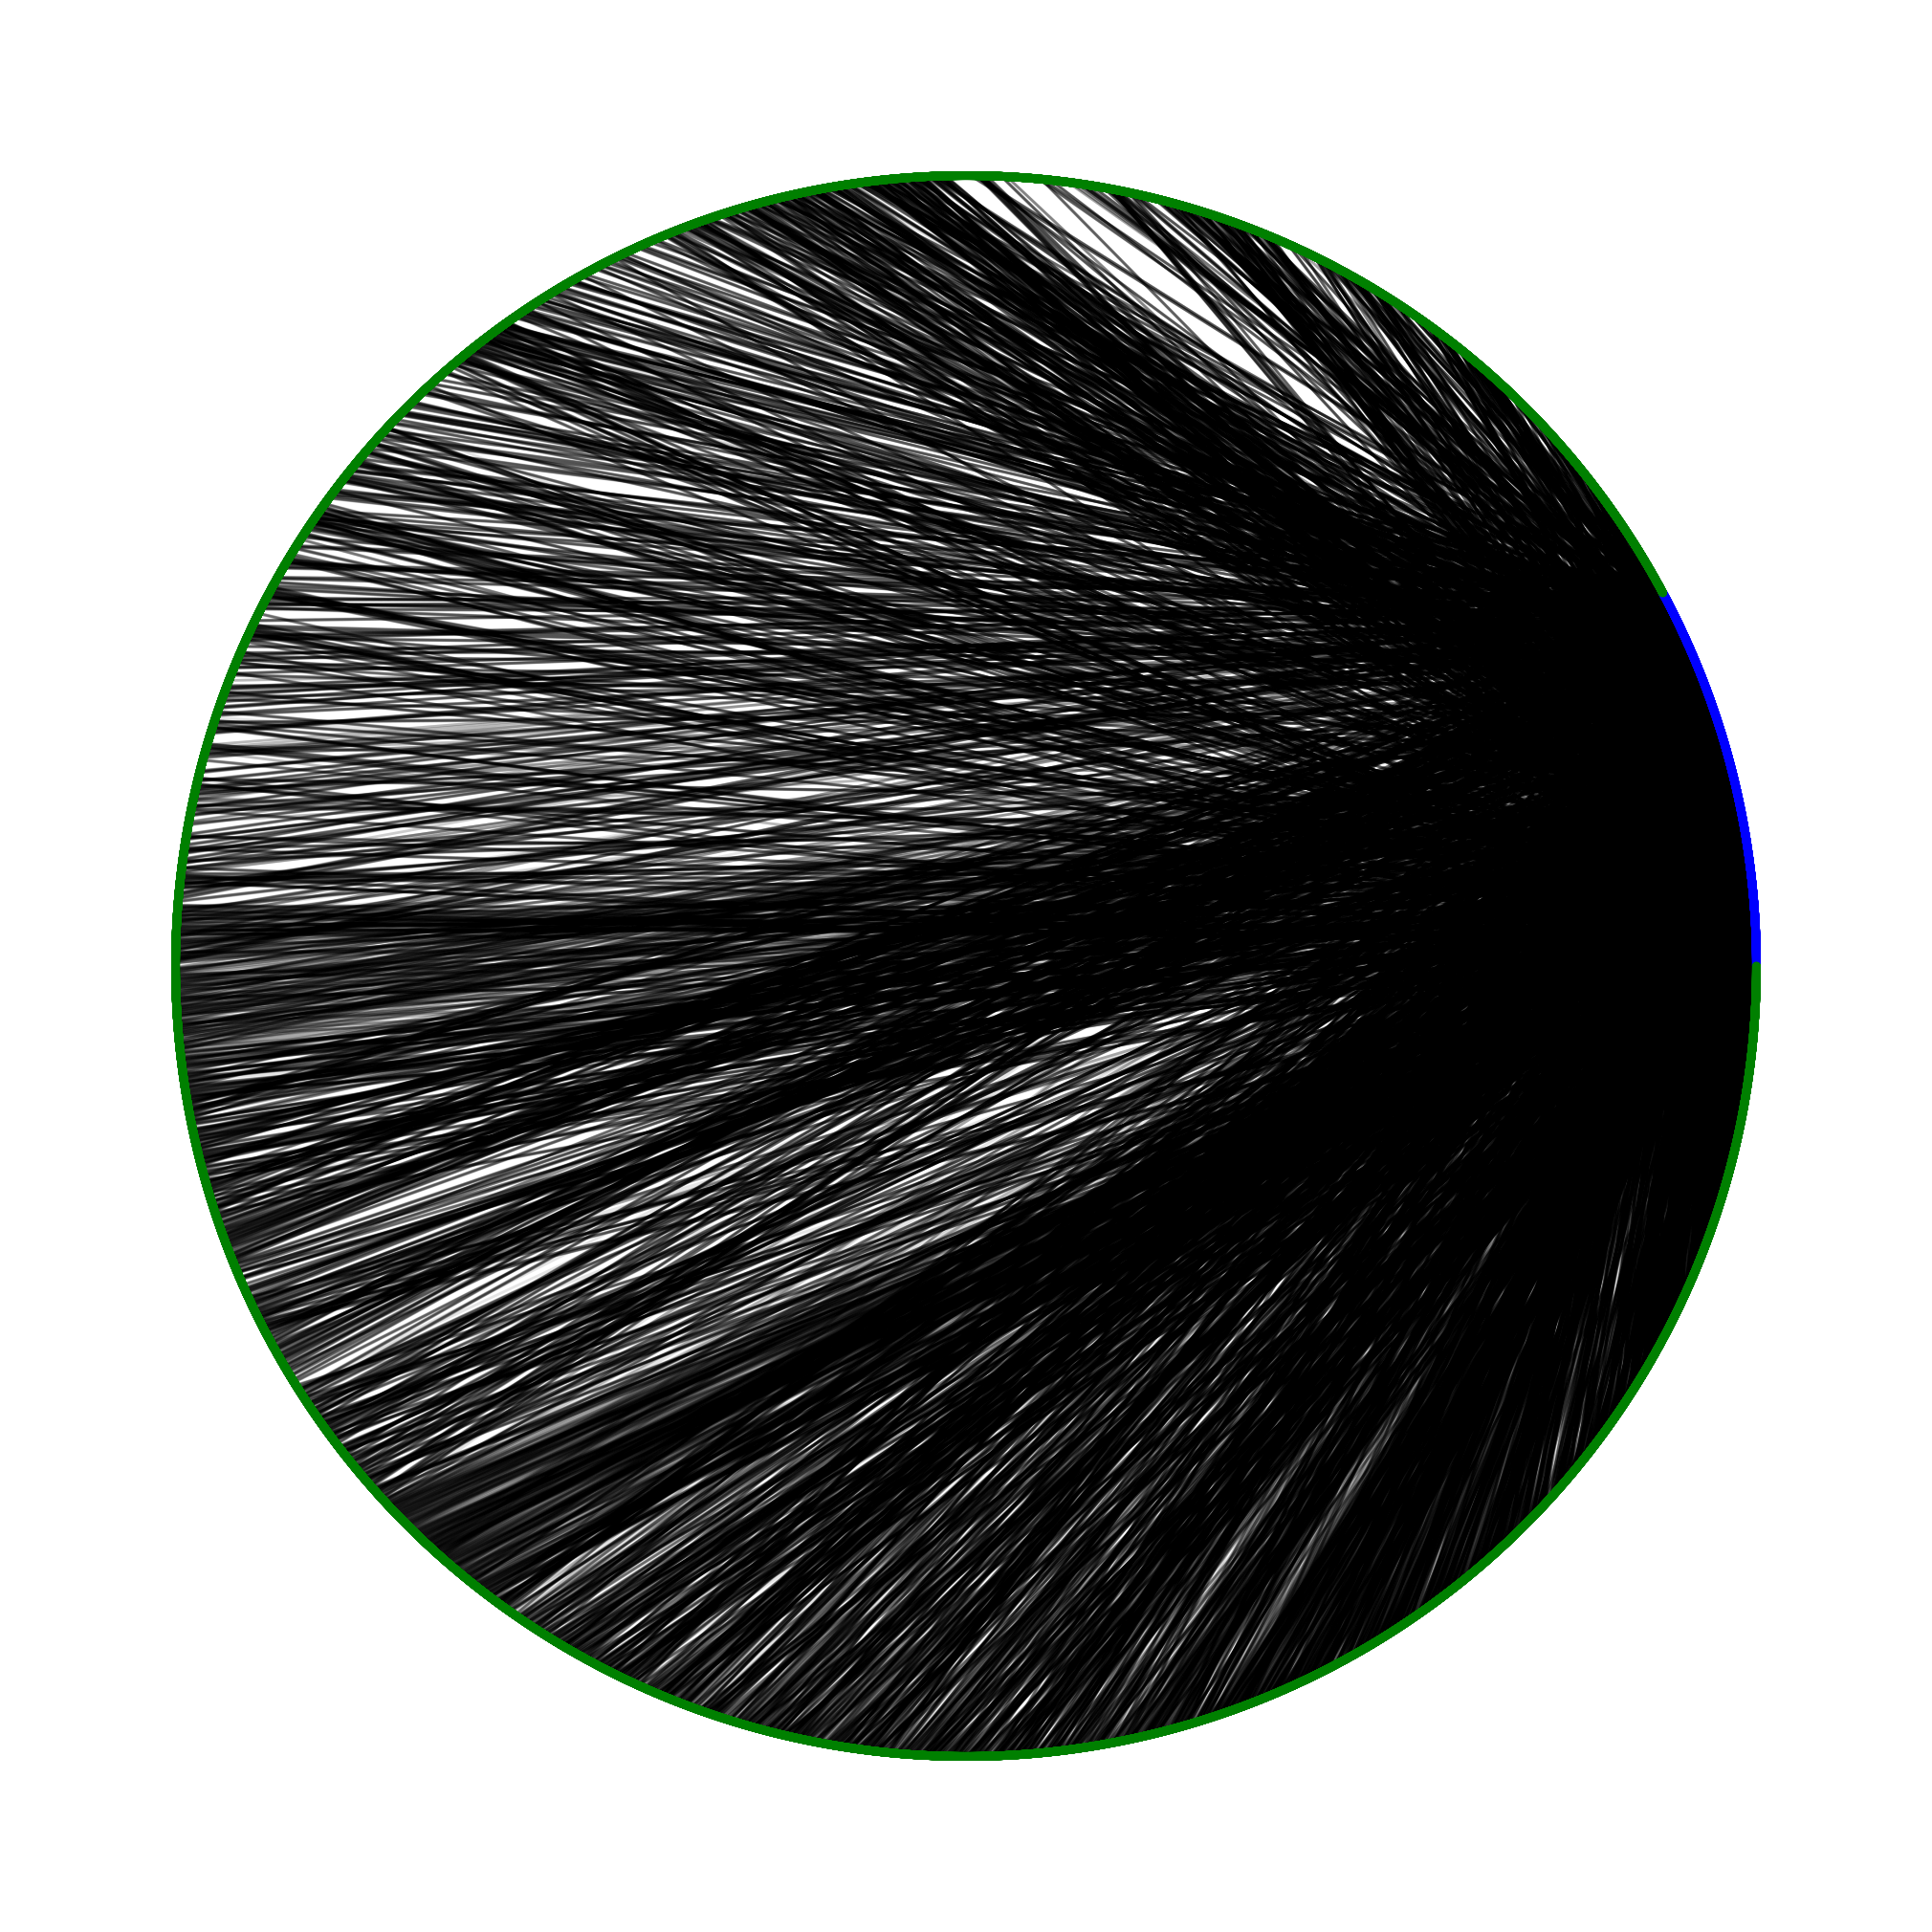

In [89]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def visualize_movie_graph(movies, clips):
    G = nx.Graph()

    # Add movie nodes
    for i, movie in movies.iterrows():
        G.add_node('movie_' + str(i), type='movie', title=movie['title'])

    # Add clip nodes
    for i, clip in clips.iterrows():
        G.add_node('clip_' + str(i), type='clip', title=clip['clip_name'])

    # Merge DataFrames on title and create edges
    merged_df = pd.merge(movies.reset_index(), clips.reset_index(), on='title', suffixes=('_movie', '_clip'))
    for _, row in merged_df.iterrows():
        G.add_edge('movie_' + str(row['index_movie']), 'clip_' + str(row['index_clip']))

    # Define node colors
    color_map = ['blue' if G.nodes[node]['type'] == 'movie' else 'green' for node in G]
    plt.figure(figsize=(20,20))
    # Draw the graph
    pos = nx.circular_layout(G)  # positions for all nodes
    nx.draw(G, pos, node_color=color_map, node_size=30, width=2, edge_color=(0, 0, 0, 0.1))
    plt.show()
    return G

# Assuming upd_movies and upd_clips are your dataframes
G = visualize_movie_graph(upd_movies, upd_clips)


Sample of a high degree node (graph is relatively sparse)

Number of nodes: 36986
Number of edges: 62250


<ipython-input-90-7a3cd2e4dc0e>:38: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(G.nodes(), sample_size)


Number of nodes in subgraph: 7
Number of edges in subgraph: 6


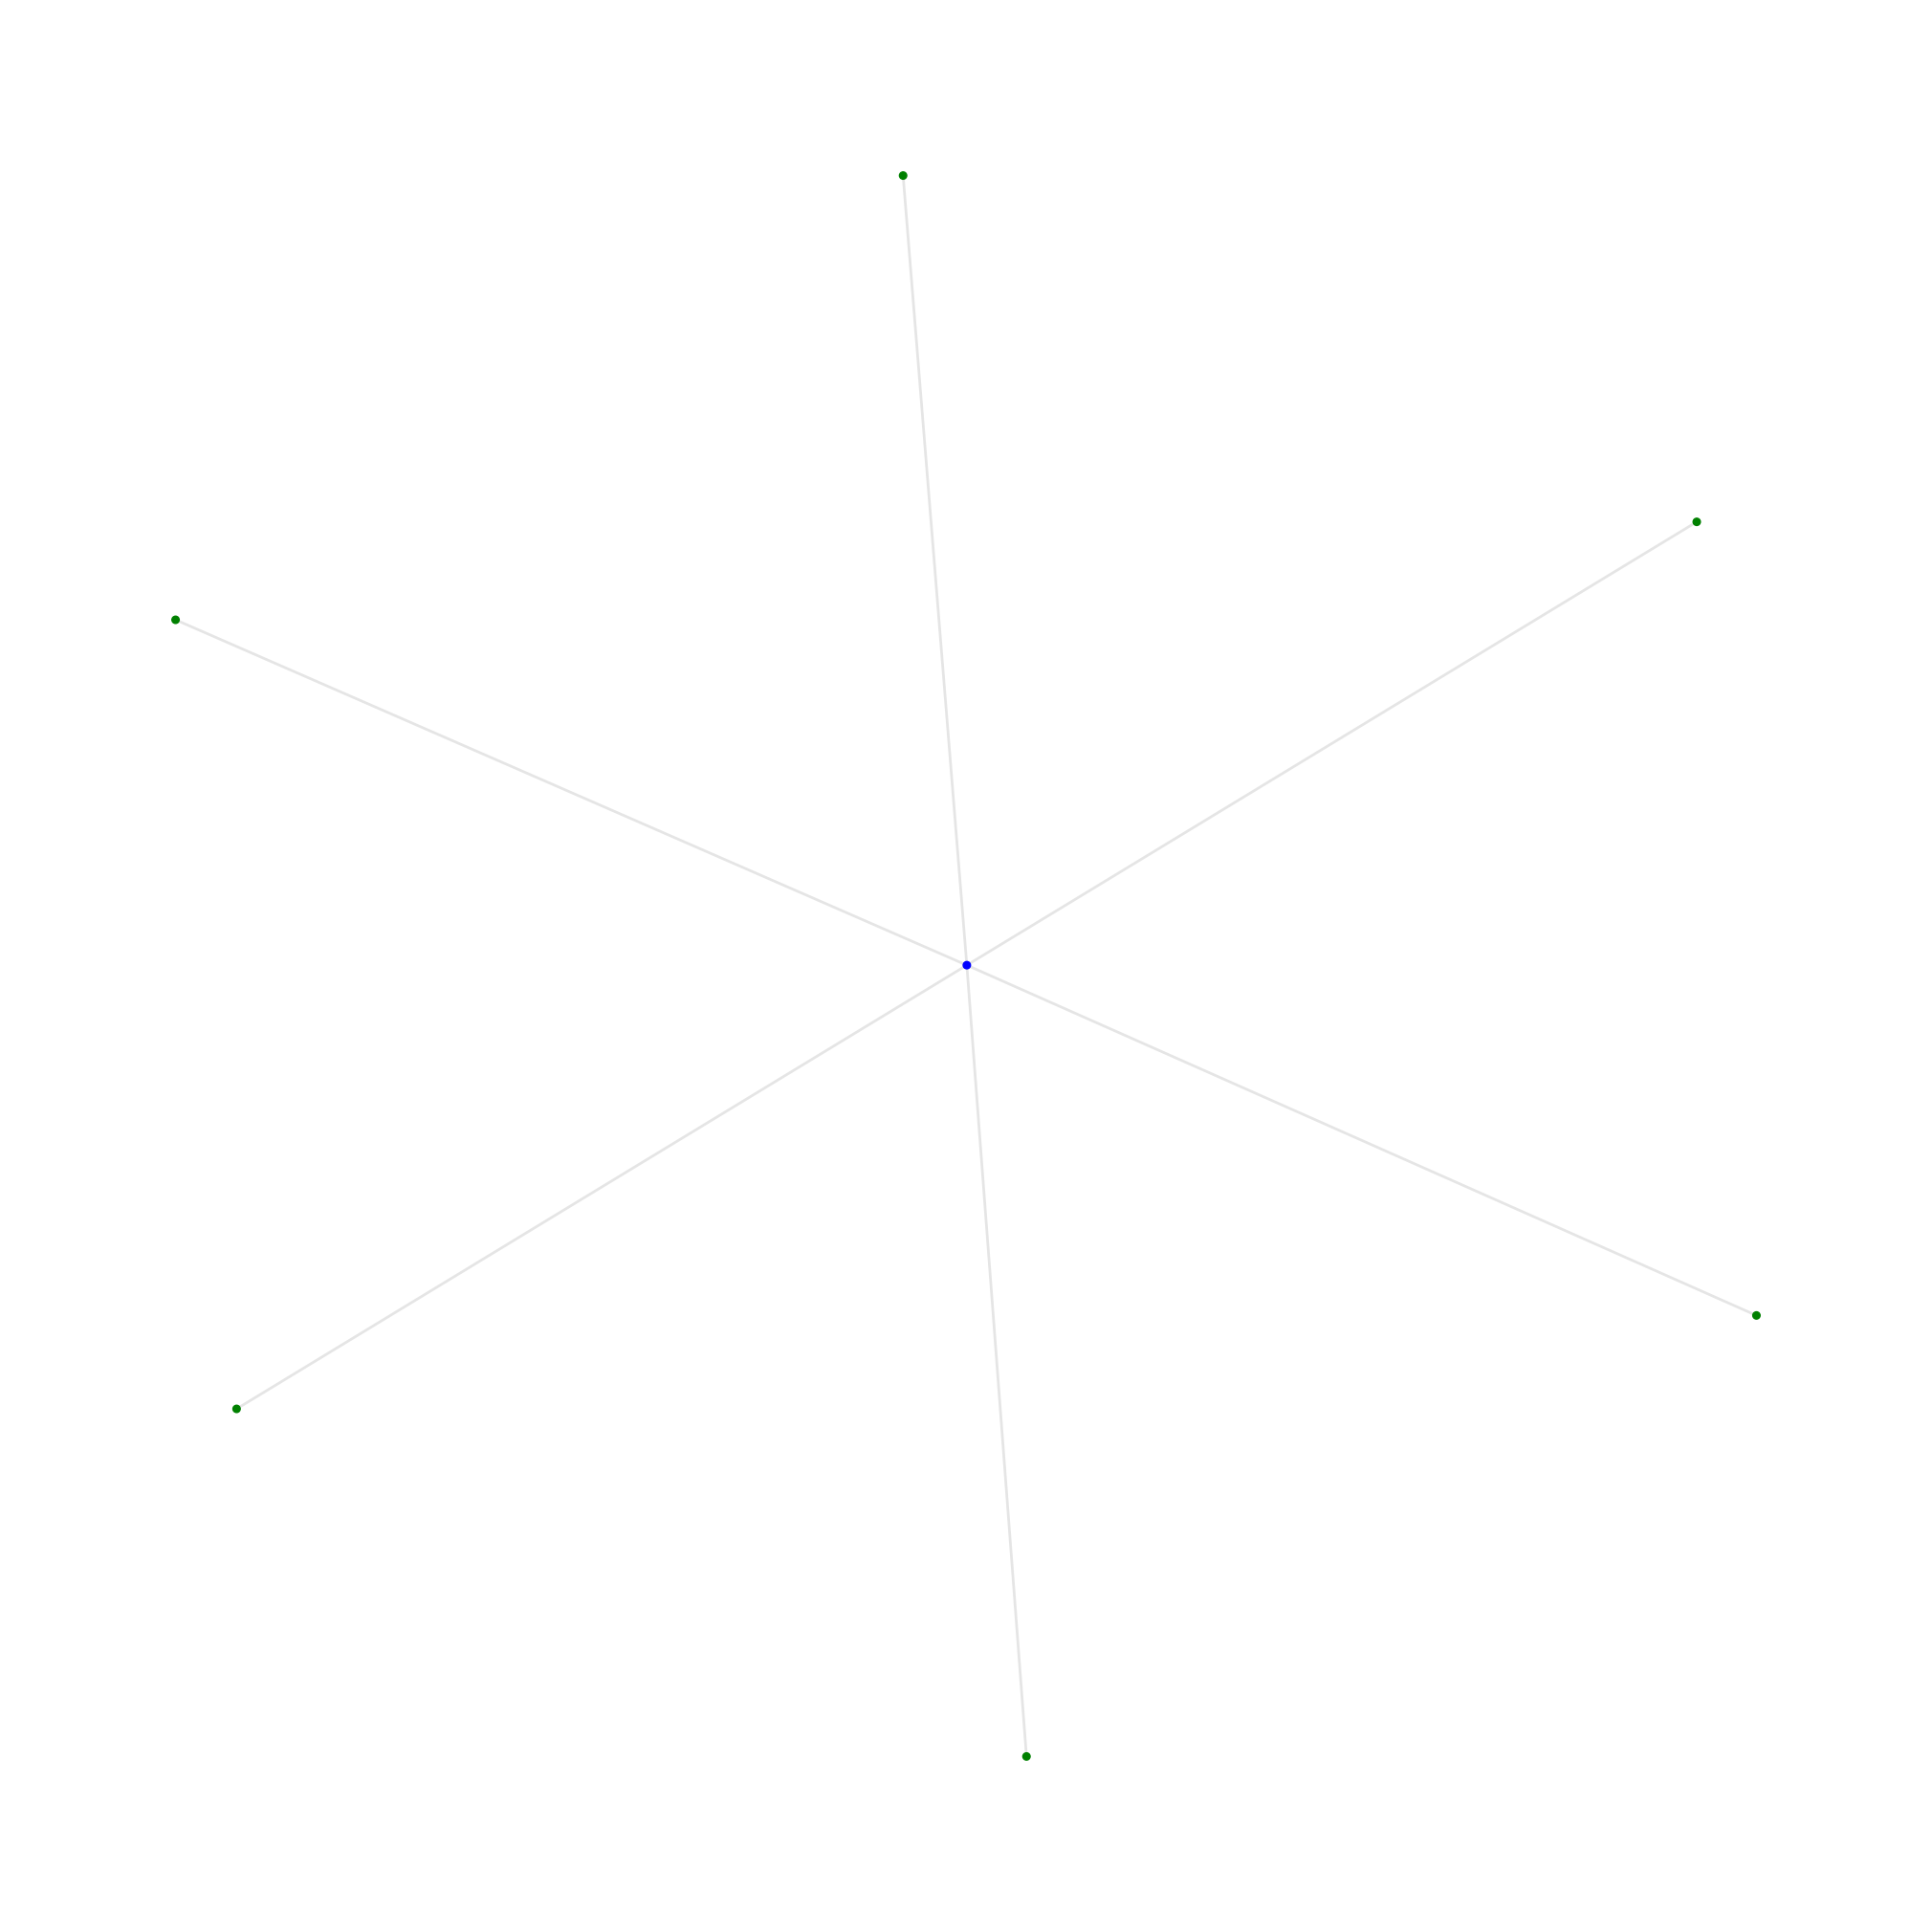

In [90]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random

def visualize_movie_graph(movies, clips, sample_size):
    G = nx.Graph()

    # Add movie nodes
    for i, movie in movies.iterrows():
        G.add_node('movie_' + str(i), type='movie', title=movie['title'])

    # Add clip nodes
    for i, clip in clips.iterrows():
        G.add_node('clip_' + str(i), type='clip', title=clip['title'])

    # Merge DataFrames on title and create edges
    merged_df = pd.merge(movies.reset_index(), clips.reset_index(), on='title', suffixes=('_movie', '_clip'))
    for _, row in merged_df.iterrows():
        G.add_edge('movie_' + str(row['index_movie']), 'clip_' + str(row['index_clip']))

    # Add a virtual node
    virtual_node_id = 'virtual_node'
    G.add_node(virtual_node_id, type='virtual')

    # Connect the virtual node to all other nodes
    for node in G.nodes():
        if node != virtual_node_id:
            G.add_edge(virtual_node_id, node)

    # Print the number of nodes and edges
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")

    # Randomly sample nodes
    if sample_size > G.number_of_nodes():
        sample_size = G.number_of_nodes()
    sampled_nodes = random.sample(G.nodes(), sample_size)

    # Create subgraph from sampled nodes
    subG = G.subgraph(sampled_nodes)

    # Find the largest connected component
    largest_cc = max(nx.connected_components(subG), key=len)
    largest_cc_subgraph = subG.subgraph(largest_cc)

    # Print the number of nodes and edges in the subgraph
    print(f"Number of nodes in subgraph: {largest_cc_subgraph.number_of_nodes()}")
    print(f"Number of edges in subgraph: {largest_cc_subgraph.number_of_edges()}")

    # Define node colors for the subgraph
    color_map = ['blue' if largest_cc_subgraph.nodes[node]['type'] == 'movie' else 'green' for node in largest_cc_subgraph]
    plt.figure(figsize=(20,20))

    # Draw the subgraph
    pos = nx.spring_layout(largest_cc_subgraph)  # positions for all nodes
    nx.draw(largest_cc_subgraph, pos, node_color=color_map, node_size=30, width=2, edge_color=(0, 0, 0, 0.1))
    plt.show()
    return largest_cc_subgraph

# Assuming upd_movies and upd_clips are your dataframes
G = visualize_movie_graph(upd_movies, upd_clips, 5000)


Add a virtual node for message passing (if we pursue this)

Number of nodes: 36986
Number of edges: 62250


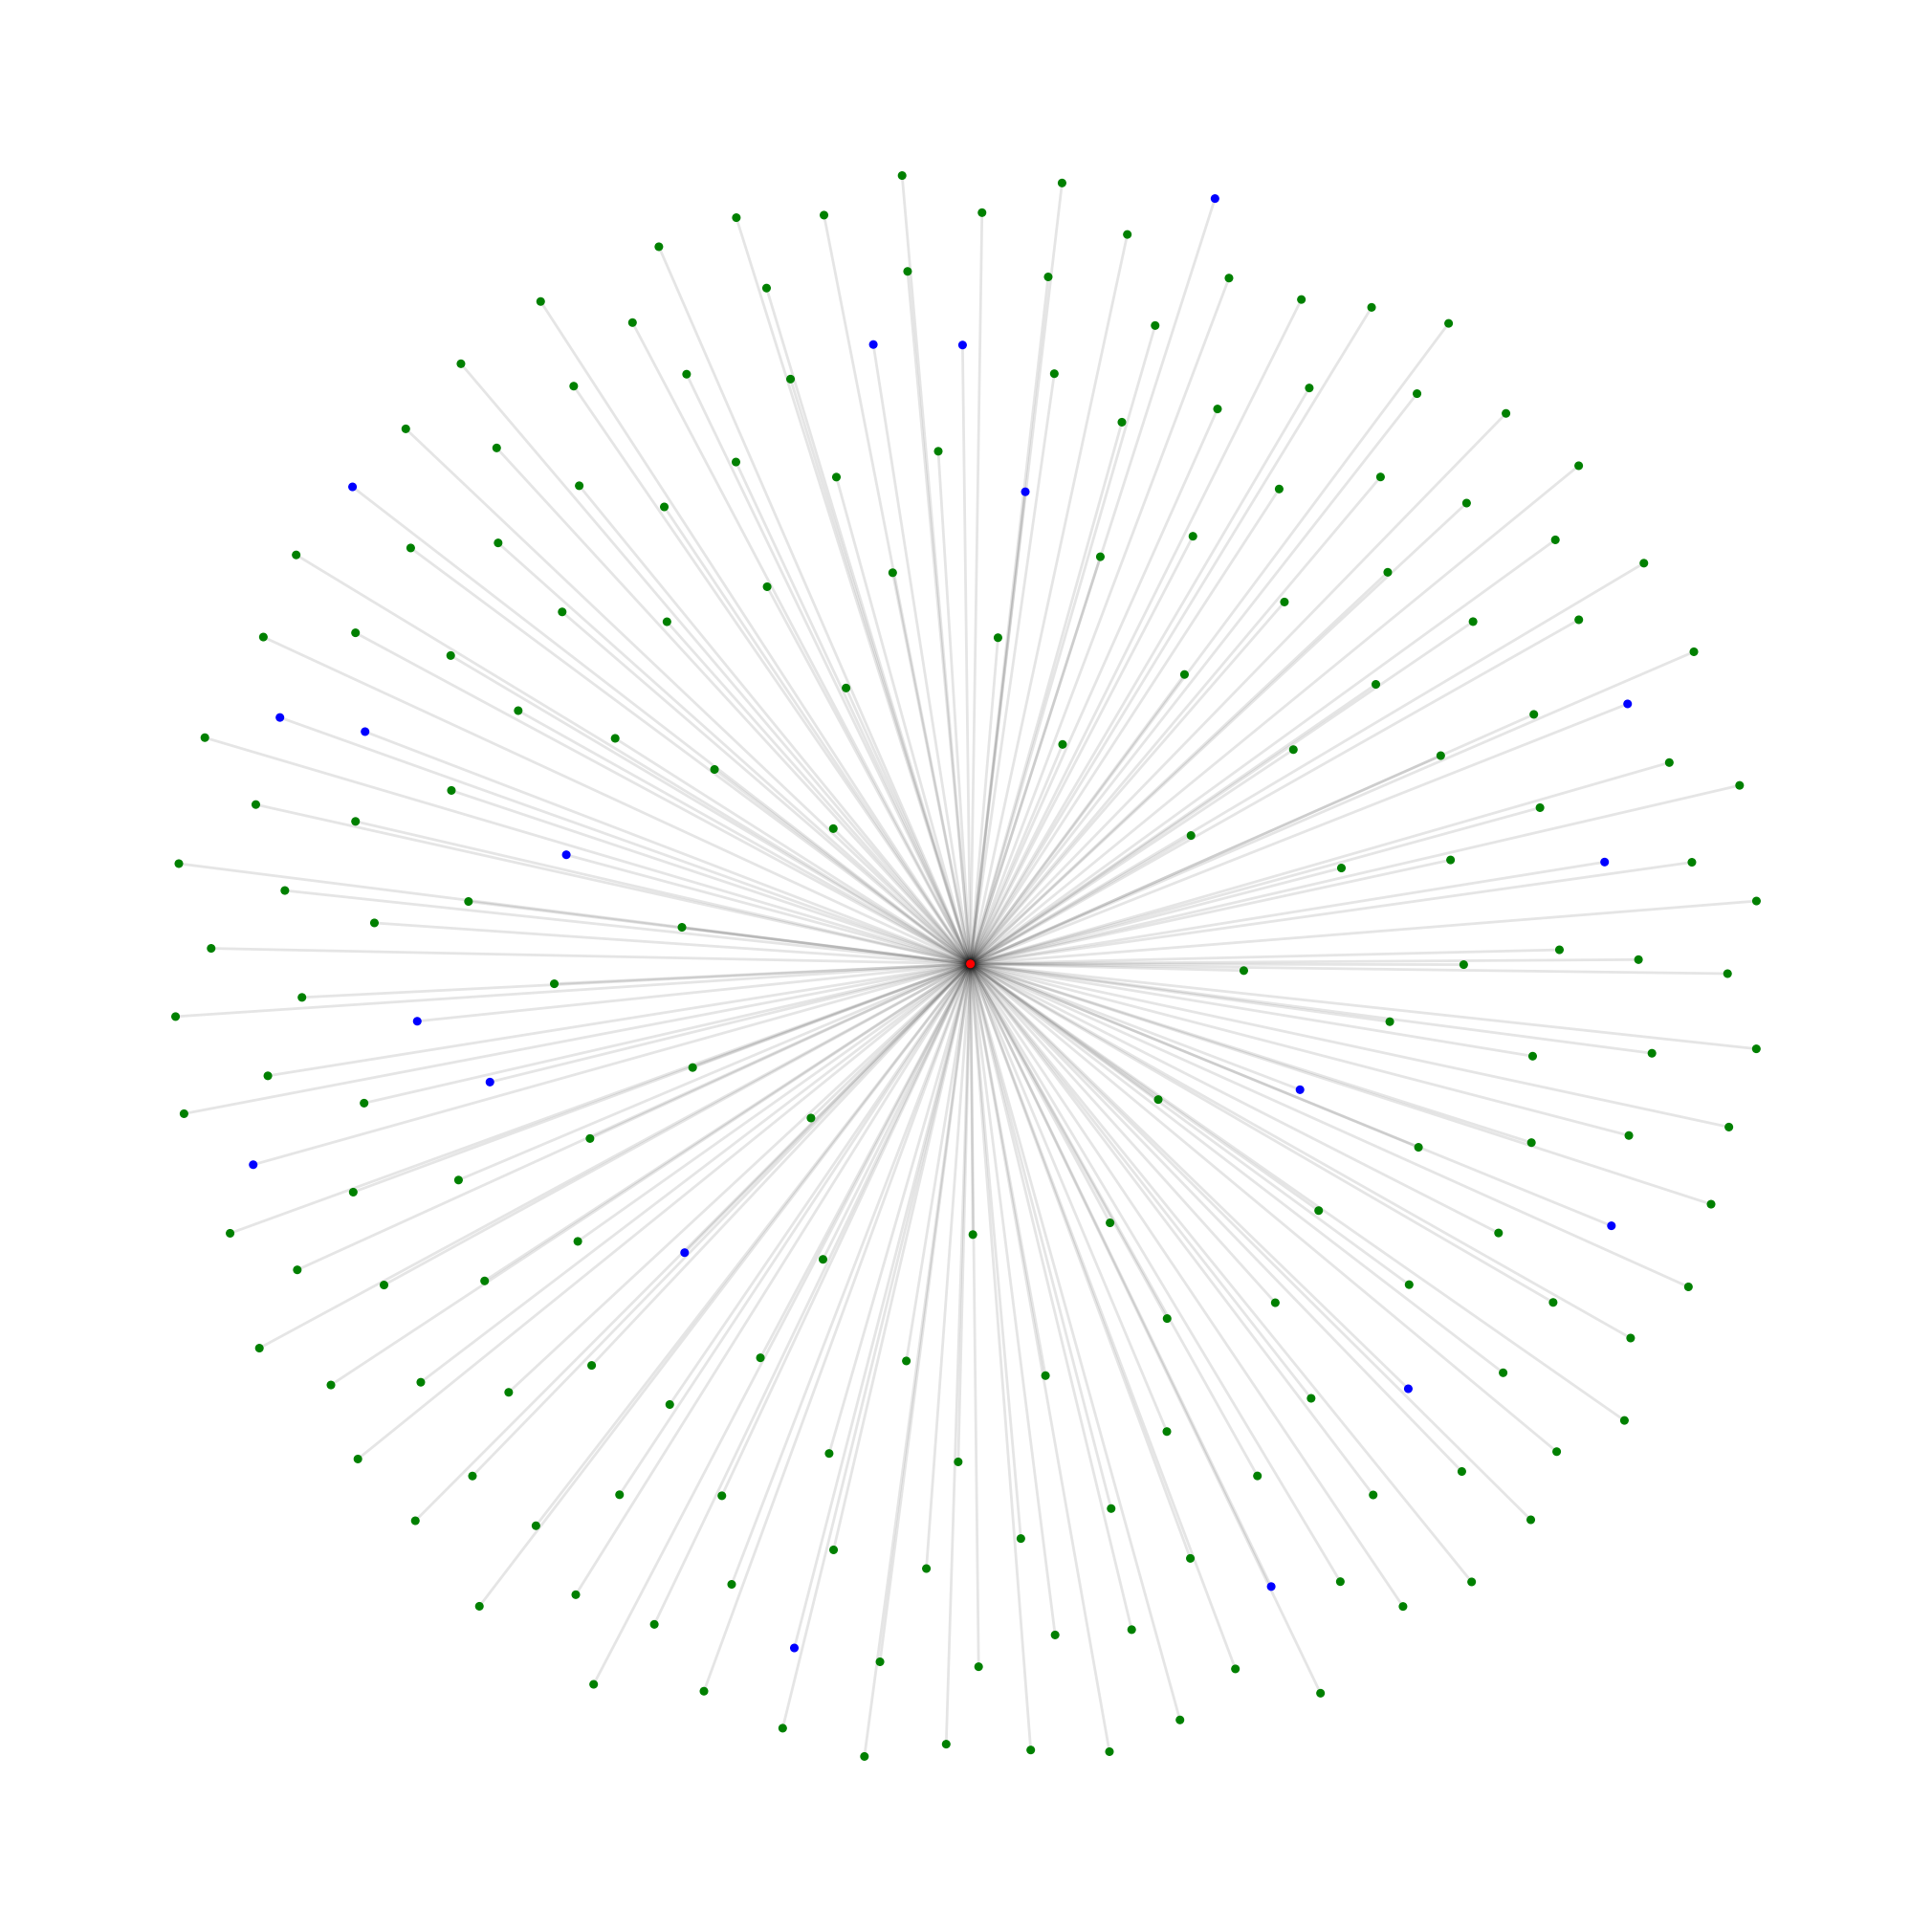

In [91]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random

def visualize_movie_graph(movies, clips, sample_size):
    G = nx.Graph()

    # Add movie nodes
    for i, movie in movies.iterrows():
        G.add_node('movie_' + str(i), type='movie', title=movie['title'])

    # Add clip nodes
    for i, clip in clips.iterrows():
        G.add_node('clip_' + str(i), type='clip', title=clip['title'])

    # Merge DataFrames on title and create edges
    merged_df = pd.merge(movies.reset_index(), clips.reset_index(), on='title', suffixes=('_movie', '_clip'))
    for _, row in merged_df.iterrows():
        G.add_edge('movie_' + str(row['index_movie']), 'clip_' + str(row['index_clip']))

    # Add a virtual node
    virtual_node_id = 'virtual_node'
    G.add_node(virtual_node_id, type='virtual')

    # Connect the virtual node to all other nodes
    for node in G.nodes():
        if node != virtual_node_id:
            G.add_edge(virtual_node_id, node)

    # Print the number of nodes and edges
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")

    # Select a fixed number of nodes connected to the virtual node
    connected_nodes = list(G.neighbors(virtual_node_id))
    if sample_size > len(connected_nodes):
        sample_size = len(connected_nodes)
    sampled_nodes = random.sample(connected_nodes, sample_size)

    # Include the virtual node in the subgraph
    sampled_nodes.append(virtual_node_id)

    # Create subgraph
    subG = G.subgraph(sampled_nodes)

    # Define node colors for the subgraph
    color_map = ['blue' if subG.nodes[node]['type'] == 'movie' else
                 'green' if subG.nodes[node]['type'] == 'clip' else
                 'red' for node in subG]  # Red for the virtual node
    plt.figure(figsize=(20,20))

    # Draw the subgraph
    pos = nx.spring_layout(subG)  # positions for all nodes
    nx.draw(subG, pos, node_color=color_map, node_size=30, width=2, edge_color=(0, 0, 0, 0.1))
    plt.show()
    return subG

subgraph_size = 200
subG = visualize_movie_graph(upd_movies, upd_clips, subgraph_size)


# Create Tensor

In [116]:
# Extract relevant columns
emotion_columns = all_clip_info.columns[-14:]  # Assuming the last 14 columns are emotion-related

# Initialize an empty list to store emotion vectors for all playlists
all_emotion_vectors = []

# Iterate over rows/playlists
for _, row in all_clip_info.iterrows():
    # Extract values for the emotion columns
    emotion_values = row[emotion_columns].values.astype(float)

    # Convert to PyTorch tensor
    emotion_tensor = torch.tensor(emotion_values, dtype=torch.float)

    # Reshape to a 1x14 vector
    emotion_vector = emotion_tensor.view(1, -1)

    # Append to the list
    all_emotion_vectors.append(emotion_vector)

# Concatenate all emotion vectors to create a tensor
all_emotion_tensors = torch.cat(all_emotion_vectors, dim=0)

# Print the result
print("All Emotion Vectors:")
print(all_emotion_tensors)


All Emotion Vectors:
tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])


In [106]:
# Edges between clips
'''
movies = all_clip_info["imdbid"].unique()
all_edges = np.array([], dtype=np.int32).reshape((0, 2))
for movie in movies:
    movie_df = all_clip_info[all_clip_info["imdbid"] == movie]
    clips = movie_df["id"].values
    # Build all combinations, as all clips are connected
    permutations = list(itertools.combinations(clips, 2))
    edges_source = [e[0] for e in permutations]
    edges_target = [e[1] for e in permutations]
    movie_edges = np.column_stack([edges_source, edges_target])
    all_edges = np.vstack([all_edges, movie_edges])
# Convert to Pytorch Geometric format
edge_index = all_edges.transpose()
edge_index # [2, num_edges]

e = torch.tensor(edge_index, dtype=torch.long)
print(e)

edge_index1 = e.t().clone().detach()
edge_index1
'''

'\nmovies = all_clip_info["imdbid"].unique()\nall_edges = np.array([], dtype=np.int32).reshape((0, 2))\nfor movie in movies:\n    movie_df = all_clip_info[all_clip_info["imdbid"] == movie]\n    clips = movie_df["id"].values\n    # Build all combinations, as all clips are connected\n    permutations = list(itertools.combinations(clips, 2))\n    edges_source = [e[0] for e in permutations]\n    edges_target = [e[1] for e in permutations]\n    movie_edges = np.column_stack([edges_source, edges_target])\n    all_edges = np.vstack([all_edges, movie_edges])\n# Convert to Pytorch Geometric format\nedge_index = all_edges.transpose()\nedge_index # [2, num_edges]\n\ne = torch.tensor(edge_index, dtype=torch.long)\nprint(e)\n\nedge_index1 = e.t().clone().detach()\nedge_index1\n'

# Pair Clip with Song

In [119]:
# Concatenate all emotion vectors to create a tensor
all_emotion_tensors = torch.cat(all_emotion_vectors, dim=0)

# Print the result
print("All Emotion Vectors:")
print(all_emotion_tensors)
def find_closest_songs(clip_vector, song_vectors, bipartite_data):
    """
    Finds the metadata of the top 2 closest songs to the given clip vector.

    Args:
    clip_vector (Tensor): A 1x14 tensor representing the emotion vector of the movie clip.
    song_vectors (Tensor): A Nx14 tensor where N is the number of songs, each row representing a song's emotion vector.
    bipartite_data(Graph): Graph with every song

    Returns:
    List[Dict]: Metadata of the top 2 closest songs.
    """
    # Calculate the Euclidean distances between the clip vector and all song vectors
    distances = torch.norm(song_vectors - clip_vector, dim=1)

    # Get the indices of the smallest two distances
    _, indices = torch.topk(distances, 2, largest=False)

    # Retrieve metadata for the closest songs
    closest_songs_metadata = [bipartite_data.songs[idx.item()] for idx in indices.data]
    indices = [idx.item() for idx in indices.data]

    return closest_songs_metadata, indices

# Example usage: Change
n_clip = 700
clip_vector = all_emotion_tensors[n_clip]
print(all_clip_info.loc[n_clip])

gsw_song_vectors = gsw_emotion_vectors[133:]
sgcn_song_vectors = sgcn_emotion_vectors[133:]
song_metadata = [...]

gsw_closest_songs_metadata, indices = find_closest_songs(clip_vector, gsw_song_vectors, bipartite_data)
print("Metadata of the closest songs with GraphSAGE:", gsw_closest_songs_metadata)

sgcn_closest_songs_metadata, indices = find_closest_songs(clip_vector, sgcn_song_vectors, bipartite_data)
print("Metadata of the closest songs with SimpleGCN:", sgcn_closest_songs_metadata)

All Emotion Vectors:
tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])
videoid                                                             G3qOB7PGBXE
year                                                                     2011.0
clip_idx                                                                      5
clip_tot                                                                     10
title                                                       No Strings Attached
clip_name                                         She's Quick Like a Puma Scene
imdbid                                                                tt1411238
description                   Emma isn't thrilled with Adam's choice of comp...
genre                                                     ['Comedy', 'Romance']
count

In [120]:
import random

clip_num = all_clip_info.shape[0]

for i in range(10):
  n_clip = random.randrange(clip_num)
  clip_vector = all_emotion_tensors[n_clip]
  print(all_clip_info.loc[n_clip])
  gsw_song_vectors = gsw_emotion_vectors[133:]
  sgcn_song_vectors = sgcn_emotion_vectors[133:]
  song_metadata = [...]

  gsw_closest_songs_metadata, gsw_indices = find_closest_songs(clip_vector, gsw_song_vectors, bipartite_data)
  print("Metadata of the closest songs with GraphSAGE:", gsw_closest_songs_metadata)
  print(gsw_song_vectors[133+gsw_indices[0]])

  sgcn_closest_songs_metadata, sgcn_indices = find_closest_songs(clip_vector, sgcn_song_vectors, bipartite_data)
  print("Metadata of the closest songs with SimpleGCN:", sgcn_closest_songs_metadata)
  print(sgcn_song_vectors[133+sgcn_indices[0]])

videoid                                                             I3G-1_l97K4
year                                                                     2009.0
clip_idx                                                                      4
clip_tot                                                                     10
title                                              Haunting of Winchester House
clip_name                                             Chasing in the Dark Scene
imdbid                                                                tt1521787
description                   Susan and Haley hide from angry ghosts in the ...
genre                                         ['Horror', 'Mystery', 'Thriller']
country                                                                 ['USA']
compound                                                                -0.6124
neg                                                                       0.238
neu                                     